In [1]:
# Установим необходимые библиотеки
!pip install catboost --quiet
!pip install optuna --quiet
!pip install dython --quiet

In [2]:
# Настроим окружение
import numpy as np
import pandas as pd
import time
from dython import nominal
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, \
cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
# Зададим скейлеры\энкодеры:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()

In [4]:
# Зададим распределения оптюны и отключим предупреждения
opt_distr_int = optuna.distributions.IntDistribution
opt_distr_float = optuna.distributions.FloatDistribution
opt_distr_cat = optuna.distributions.CategoricalDistribution
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
# Настроим параметры отображения графиков
plt.style.use("seaborn-whitegrid")
%matplotlib inline

In [6]:
# Настроим параметры отображения в pandas
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 0)
pd.set_option('display.float_format', '{:,.3f}'.format)

## Изучение исходных данных

Имеются данные о телесмотрении 3244 пользователей и их характеристиках.

Задача - восстановить характеристики "Оператор", "Есть ли Интернет", "Состав ДХ" на тестовых данных.

In [7]:
data_train = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_agency2/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_agency2/test.csv')
data_sample = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_agency2/sampleSubmission.csv')

In [8]:
display(data_train)
data_train.info()

,id,hhid,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,Телесмотрение в вечернее время Пн-Пт,Телесмотрение в прайм тайм Пн-Пт,Общее телесмотрение в выходные,Телесмотрение ночью в выходные,Телесмотрение утром в выходные,Телесмотрение в рабочее время в выходные,Телесмотрение вечером в выходные,Телесмотрение в прайм тайм в выходные,Просмотр жанра кино в рабочее время,Просмотр жанра кино в праздники,Просмотр жанра приключения в рабочее время,Просмотр жанра приключение в праздники,Просмотра жанра сад в рабочее время,Просмотр жанра сад в праздники,Просмотра жанра комедия в рабочее время,Просмотр жанра комедия в праздники,Просмотр жанра хоби в рабочее время,Просмотр жанра хобби в праздники,Просмотр жанра спорт в рабочее время,Просмотр жанра спорт в праздники,Просмотр жанра музыка в рабочее время,Просмотр жанра музыка в праздники,Просмотр жанра образования в рабочее время,Просмотр жанра образование в праздники,Размер ДХ,Тип ресивера,Оператор,Есть ли Интернет,Состав ДХ,ФО,Тип нас.пункта,Почтовый индекс
0,0,3348,647,437,15.000,12,120,63,195.000,0,0,12,120,63,452,437,15,0,0,0,0,414,0,0,0,1,0,0,0,21,0,0,0,0,0,1,4.000,Ресивер с поддержкой HDTV,Подключен только к Триколор ТВ,Нет,Нет членов семьи в возрасте 55+ лет и есть до ...,Северо-Западный федеральный округ,Город с численностью от 45 тыс. до 400 тыс.,182180
1,1,4182,2657,538,363.000,1582,174,0,415.000,133,0,282,0,0,2242,405,363,1300,174,0,4,67,0,30,26,3,0,108,103,91,0,0,0,0,1,109,4.000,Ресивер с поддержкой HEVC,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...,Уральский федеральный округ,Город с численностью менее 45 тыс.,457024
2,2,1233,1385,0,49.000,1134,202,0,729.000,0,49,571,109,0,656,0,0,563,93,0,0,0,0,0,0,0,0,0,0,0,18,16,0,0,0,0,2.000,Ресивер с поддержкой HDTV,Подключен только к Триколор ТВ,Есть,Есть члены семьи в возрасте 55+ лет и нет до 1...,Южный федеральный округ,Город более 400 тыс.,350901
3,3,4813,2861,607,857.000,1374,23,0,"1,249.000",294,270,662,23,0,1612,313,587,712,0,0,115,116,16,12,4,0,75,0,75,22,59,0,0,0,11,11,2.000,Ресивер с поддержкой HEVC,Подключен только к Триколор ТВ,Нет,Есть члены семьи в возрасте 55+ лет и нет до 1...,Приволжский федеральный округ,Сельский населенный пункт,452774
4,4,1782,478,174,44.000,53,79,128,260.000,0,0,53,79,128,218,174,44,0,0,0,0,0,0,0,62,13,0,0,0,173,0,0,0,0,0,0,4.000,Ресивер с поддержкой HDTV,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...,Северо-Западный федеральный округ,Сельский населенный пункт,168068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,3239,908,697,0,8.000,571,118,0,244.000,0,0,126,118,0,453,0,8,445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000,Ресивер с поддержкой HDTV,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...,Центральный федеральный округ,Сельский населенный пункт,309830
3240,3240,4567,532,2,0.000,6,164,360,258.000,1,0,6,71,180,274,1,0,0,93,180,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.000,Ресивер с поддержкой HEVC,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...,Северо-Западный федеральный округ,Город с численностью менее 45 тыс.,238758
3241,3241,2493,1153,212,198.000,743,0,0,505.000,29,197,279,0,0,648,183,1,464,0,0,4,2,21,40,6,0,0,0,3,124,0,0,0,0,0,0,2.000,Ресивер с поддержкой HEVC,Подключен только к Триколор ТВ,Нет,Есть члены семьи в возрасте 55+ лет и нет до 1...,Центральный федеральный округ,Сельский населенный пункт,307341
3242,3242,3821,871,299,150.000,422,0,0,410.000,215,150,45,0,0,461,84,0,377,0,0,0,2,0,0,0,0,0,0,21,20,0,0,0,0,194,2,3.000,Ресивер с поддержкой HEVC,Подключен только к Триколор ТВ,Есть,Есть члены семьи в возр

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244 entries, 0 to 3243
Data columns (total 44 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          3244 non-null   int64  
 1   hhid                                        3244 non-null   int64  
 2   Общее телесмотрение                         3244 non-null   int64  
 3   Телесмотрение ночью                         3244 non-null   int64  
 4   Телесмотрение утром                         3219 non-null   float64
 5   Телесмотрение в рабочее время               3244 non-null   int64  
 6   Телесмотрение в вечернее время              3244 non-null   int64  
 7   Телесмотрение в прайм тайм                  3244 non-null   int64  
 8   Общее телесмотрение Пн-Пт                   3219 non-null   float64
 9   Телесмотрение ночью Пн-Пт                   3244 non-null   int64  
 10  Телесмотрени

In [9]:
display(data_test)
data_test.info()

,id,hhid,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,Телесмотрение в вечернее время Пн-Пт,Телесмотрение в прайм тайм Пн-Пт,Общее телесмотрение в выходные,Телесмотрение ночью в выходные,Телесмотрение утром в выходные,Телесмотрение в рабочее время в выходные,Телесмотрение вечером в выходные,Телесмотрение в прайм тайм в выходные,Просмотр жанра кино в рабочее время,Просмотр жанра кино в праздники,Просмотр жанра приключения в рабочее время,Просмотр жанра приключение в праздники,Просмотра жанра сад в рабочее время,Просмотр жанра сад в праздники,Просмотра жанра комедия в рабочее время,Просмотр жанра комедия в праздники,Просмотр жанра хоби в рабочее время,Просмотр жанра хобби в праздники,Просмотр жанра спорт в рабочее время,Просмотр жанра спорт в праздники,Просмотр жанра музыка в рабочее время,Просмотр жанра музыка в праздники,Просмотр жанра образования в рабочее время,Просмотр жанра образование в праздники,Размер ДХ,Тип ресивера,ФО,Тип нас.пункта,Почтовый индекс
0,3244,5299,2613,266,265,1973,109,0,1004,52,149,759,44,0,1609,214,116,1214,65,0,1,2,0,0,0,0,0,0,49,203,51,111,0,0,2,9,1,Ресивер с поддержкой HDTV,Центральный федеральный округ,Город с численностью менее 45 тыс.,152470
1,3245,4357,1914,1011,512,391,0,0,602,443,67,92,0,0,1312,568,445,299,0,0,127,194,36,69,2,6,2,0,157,54,0,0,21,0,36,9,4,Ресивер с поддержкой HEVC,Приволжский федеральный округ,Сельский населенный пункт,452151
2,3246,347,1044,0,0,973,41,30,694,0,0,623,41,30,350,0,0,350,0,0,0,0,0,0,0,0,0,0,0,0,53,8,0,0,0,0,2,Ресивер с поддержкой HDTV,Центральный федеральный округ,Город более 400 тыс.,153045
3,3247,4050,661,0,0,524,120,17,650,0,0,513,120,17,11,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,Ресивер с поддержкой HEVC,Центральный федеральный округ,Сельский населенный пункт,143081
4,3248,5199,2788,1295,712,770,0,11,1010,581,358,71,0,0,1778,714,354,699,0,11,15,92,109,140,0,0,0,0,313,256,0,0,0,0,29,198,1,Ресивер с поддержкой HEVC,Сибирский федеральный округ,Город с численностью менее 45 тыс.,662340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,4050,565,3440,431,300,1750,463,496,1604,118,269,1052,103,62,1836,313,31,698,360,434,118,312,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,Ресивер с поддержкой HDTV,Центральный федеральный округ,Город более 400 тыс.,153008
807,4051,4747,914,7,20,865,22,0,400,0,0,385,15,0,514,7,20,480,7,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,2,Ресивер с поддержкой HEVC,Центральный федеральный округ,Сельский населенный пункт,309740
808,4052,4400,1331,1,0,526,474,330,754,1,0,401,172,180,577,0,0,125,302,150,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,Ресивер с поддержкой HDTV,Южный федеральный округ,Город более 400 тыс.,350088
809,4053,3089,2748,788,440,1260,189,71,491,164,0,254,69,4,2257,624,440,1006,120,67,51,229,4,0,18,182,47,2,20,7,0,9,0,0,4,178,2,Ресивер с поддержкой HEVC,Сибирский федеральный округ,Город более 400 тыс.,656012


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   id                                          811 non-null    int64 
 1   hhid                                        811 non-null    int64 
 2   Общее телесмотрение                         811 non-null    int64 
 3   Телесмотрение ночью                         811 non-null    int64 
 4   Телесмотрение утром                         811 non-null    int64 
 5   Телесмотрение в рабочее время               811 non-null    int64 
 6   Телесмотрение в вечернее время              811 non-null    int64 
 7   Телесмотрение в прайм тайм                  811 non-null    int64 
 8   Общее телесмотрение Пн-Пт                   811 non-null    int64 
 9   Телесмотрение ночью Пн-Пт                   811 non-null    int64 
 10  Телесмотрение утром Пн-Пт 

Известно, что время смотрения дано в секундах

Логично предположить, что id - идентификатор объекта в общей таблице, hhid - идентификатор домохозяйства (household id)

Несоответствие типа данных в нескольких признаках тренировочных данных объясняется наличием пропусков в них

## Исследование данных

In [10]:
# Выделим различные признаки:
categorical = ['Размер ДХ', 'Тип ресивера', 'ФО', 'Тип нас.пункта']
numeric = list(data_train.iloc[:,2:36].columns)
other = ['id', 'hhid', 'Почтовый индекс']
target = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']

### Распределение признаков в данных

#### Категориальные признаки

In [11]:
# Определим функцию для отображения распределения категориальных признаков
def get_cat_barplot(column, size=(14,4)):

  values_train = data_train[column].value_counts().sort_index()
  values_test = data_test[column].value_counts().sort_index()
  plt.figure(figsize=size)

  plt.subplot(1,2,1)
  plt.bar(x=values_train.index, height=values_train)
  plt.xticks(values_train.index, values_train.index.values, rotation=30)
  plt.title(f'Распределение признака {column} на train')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Частота')

  plt.subplot(1,2,2)
  plt.bar(x=values_test.index, height=values_test)
  plt.xticks(values_test.index, values_test.index.values, rotation=30)
  plt.title(f'Распределение признака {column} на test')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Частота')
  
  plt.tight_layout()
  plt.show()

  result = pd.concat(
          [values_train,
           data_train[column].value_counts(normalize=True).sort_index(),
           values_test,
           data_test[column].value_counts(normalize=True).sort_index()]
           , axis=1)
  
  result.columns = [
      f'Количество',
      f'Распределение {column} Train',
      f'Количество',
      f'Распределение {column} Test'
      ]

  display(
      result.style.format(
          '{:.2%}'.format, 
          subset=[f'Распределение {column} Train',
                  f'Распределение {column} Test']
                  ))

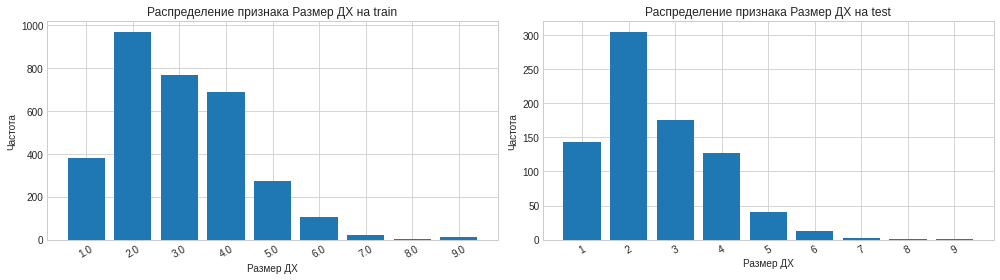

,Количество,Распределение Размер ДХ Train,Количество,Распределение Размер ДХ Test
1.0,381,11.84%,144,17.76%
2.0,968,30.07%,305,37.61%
3.0,767,23.83%,176,21.70%
4.0,686,21.31%,127,15.66%
5.0,273,8.48%,41,5.06%
6.0,107,3.32%,13,1.60%
7.0,22,0.68%,3,0.37%
8.0,2,0.06%,1,0.12%
9.0,13,0.40%,1,0.12%


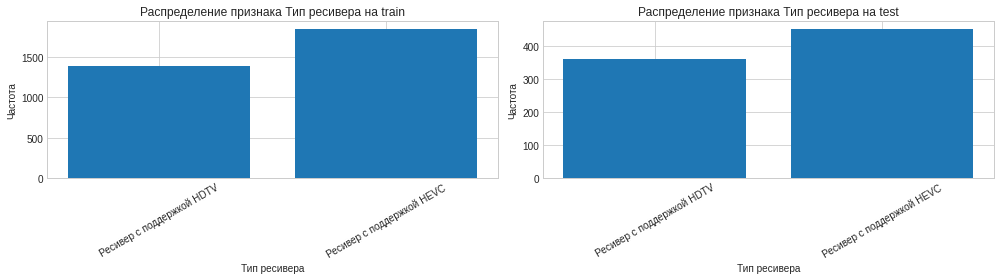

,Количество,Распределение Тип ресивера Train,Количество,Распределение Тип ресивера Test
Ресивер с поддержкой HDTV,1395,43.00%,360,44.39%
Ресивер с поддержкой HEVC,1849,57.00%,451,55.61%


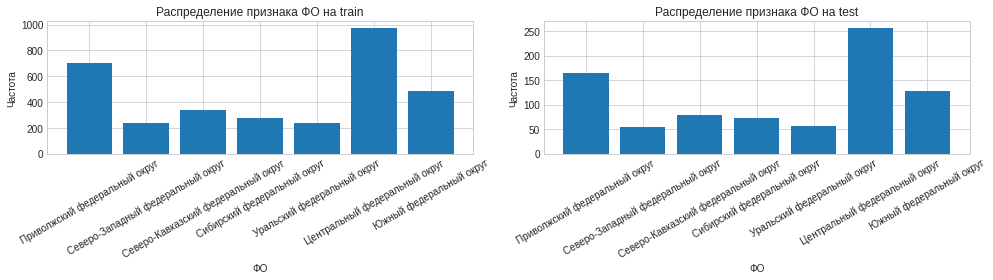

,Количество,Распределение ФО Train,Количество,Распределение ФО Test
Приволжский федеральный округ,704,21.70%,164,20.22%
Северо-Западный федеральный округ,236,7.27%,54,6.66%
Северо-Кавказский федеральный округ,338,10.42%,79,9.74%
Сибирский федеральный округ,272,8.38%,72,8.88%
Уральский федеральный округ,236,7.27%,57,7.03%
Центральный федеральный округ,976,30.09%,257,31.69%
Южный федеральный округ,482,14.86%,128,15.78%


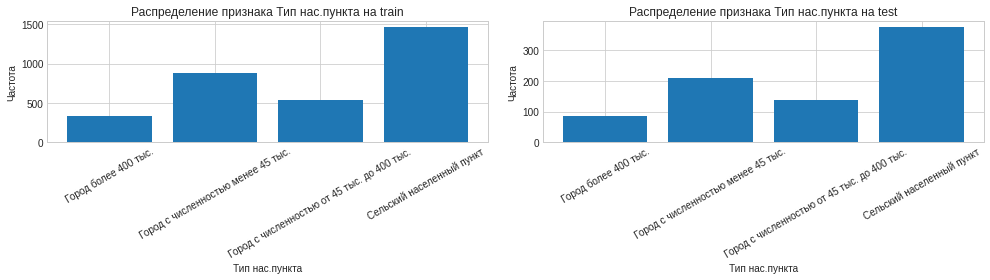

,Количество,Распределение Тип нас.пункта Train,Количество,Распределение Тип нас.пункта Test
Город более 400 тыс.,334,10.38%,86,10.60%
Город с численностью менее 45 тыс.,886,27.52%,211,26.02%
Город с численностью от 45 тыс. до 400 тыс.,536,16.65%,138,17.02%
Сельский населенный пункт,1463,45.45%,376,46.36%


In [12]:
for col in categorical:
  get_cat_barplot(col)

- Заметим малое количество наблюдений в признаке Размер ДХ, где кол-вол человек в семье превышает шесть
- Из графиков можно видеть, что распределения категориальных признаков в тренировочных и тестовых данных значимо не различаются

#### Количественные признаки

In [13]:
# Определим функцию для отображения распределений количественных признаков
def get_num_plot(column, size=(16,6)):

  plt.figure(figsize=size)

  plt.subplot(2,2,1)
  sns.histplot(data_train[column], bins='auto', kde=True)
  plt.title(f'Гистограмма распределения {column} Train')
  plt.subplot(2,2,3)
  sns.boxplot(x=data_train[column])
  plt.title(f'Диаграмма размаха {column} Train')

  plt.subplot(2,2,2)
  sns.histplot(data_test[column], bins='auto', kde=True)
  plt.title(f'Гистограмма распределения {column} Test')
  plt.subplot(2,2,4)
  sns.boxplot(x=data_test[column])
  plt.title(f'Диаграмма размаха {column} Test')

  plt.tight_layout()
  plt.show()
  print('\n')

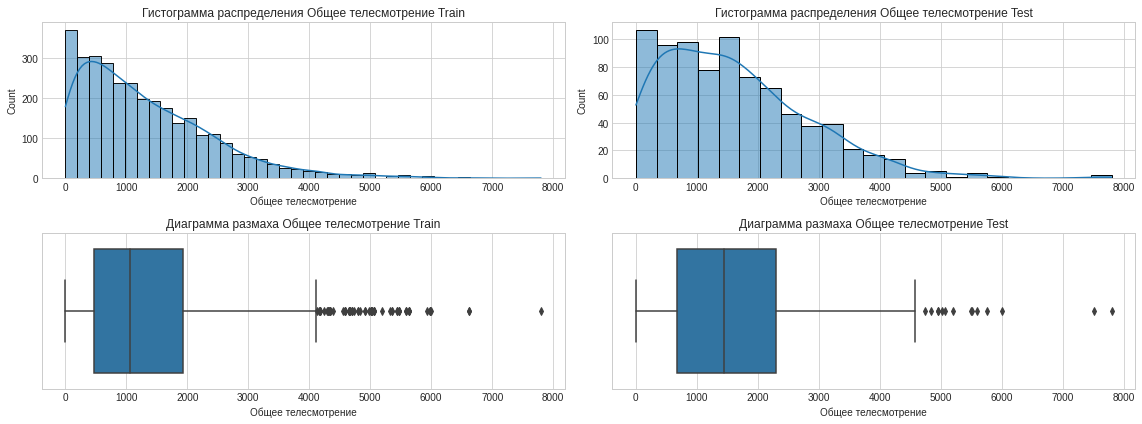

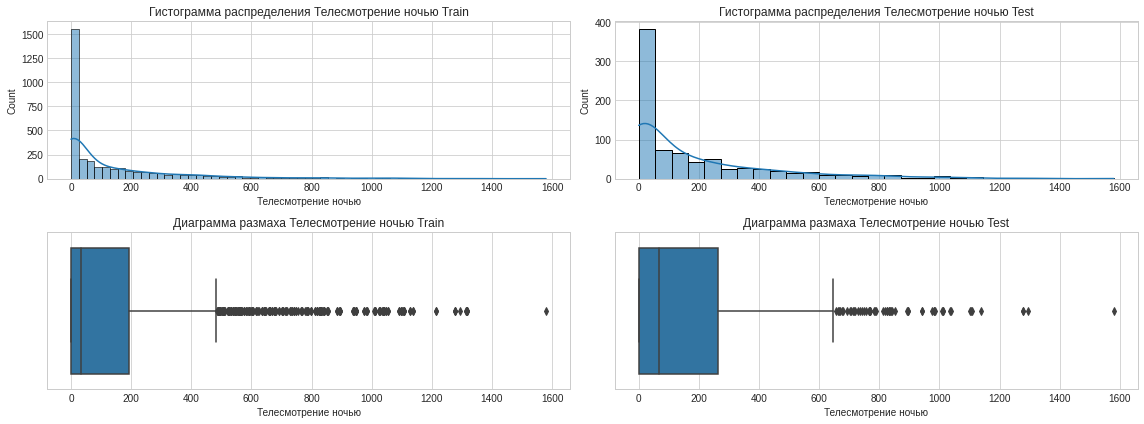

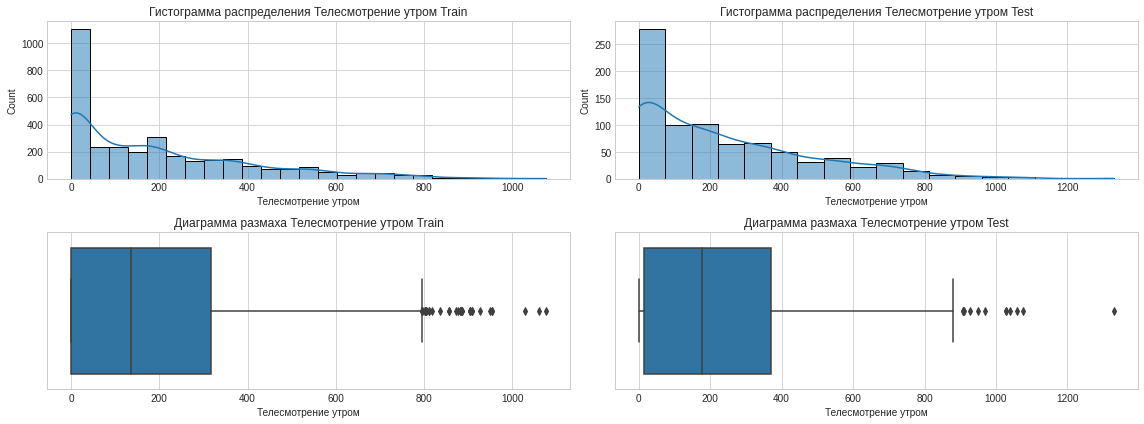

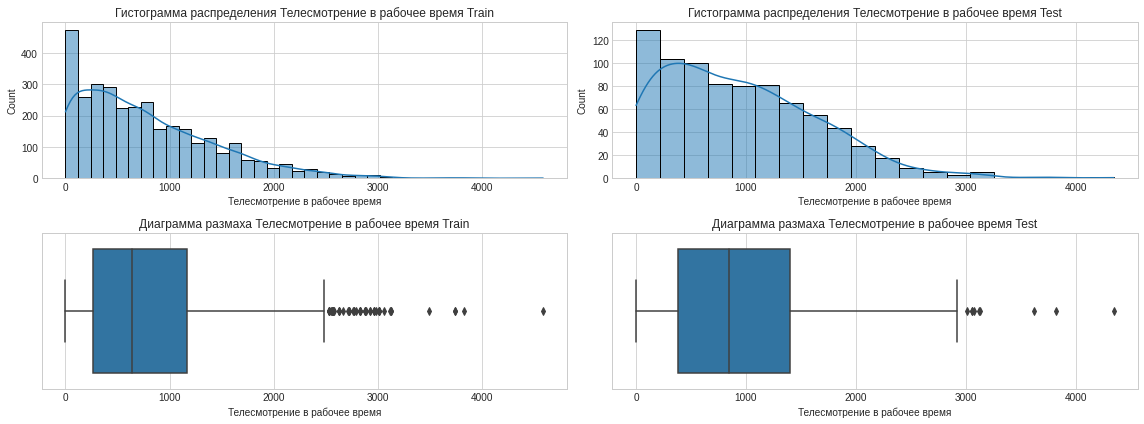

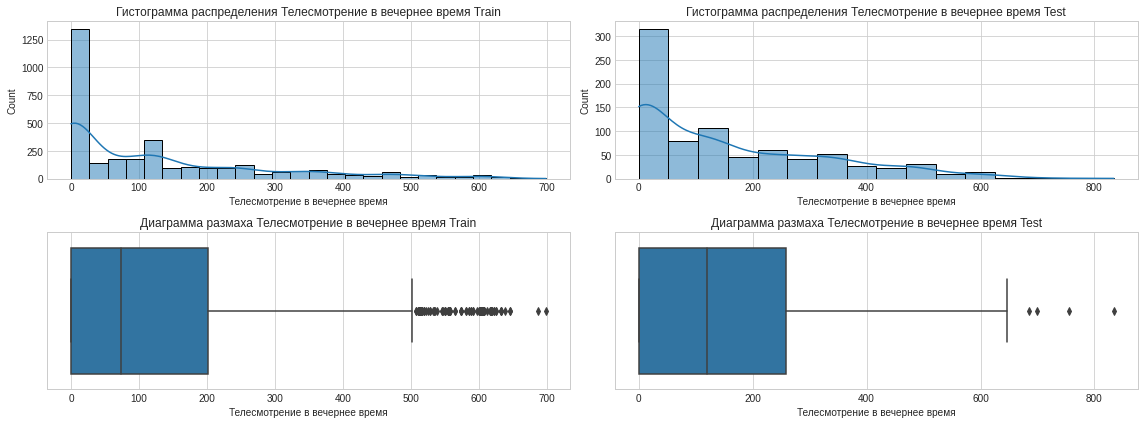

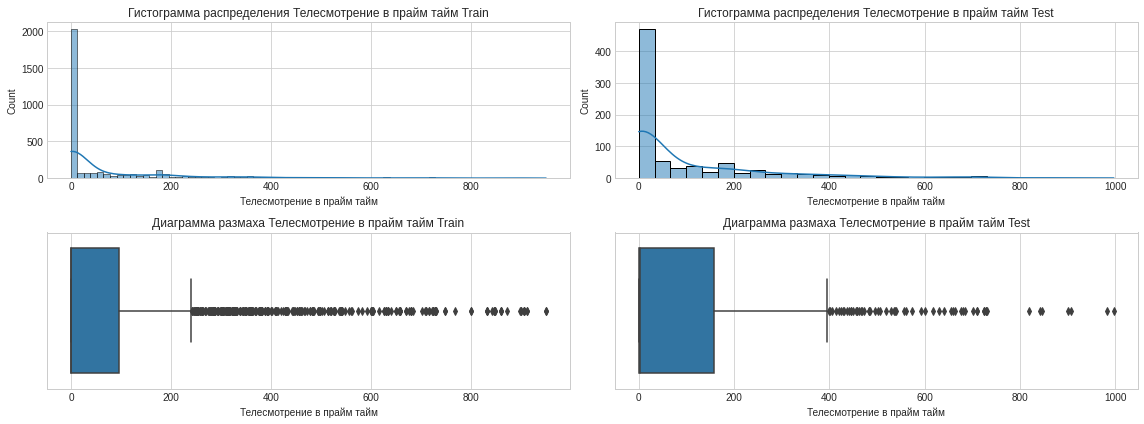

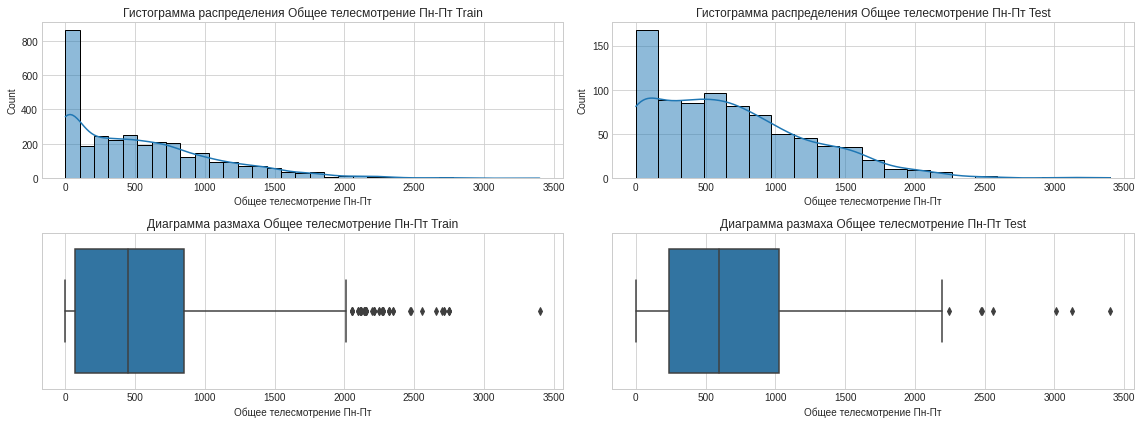

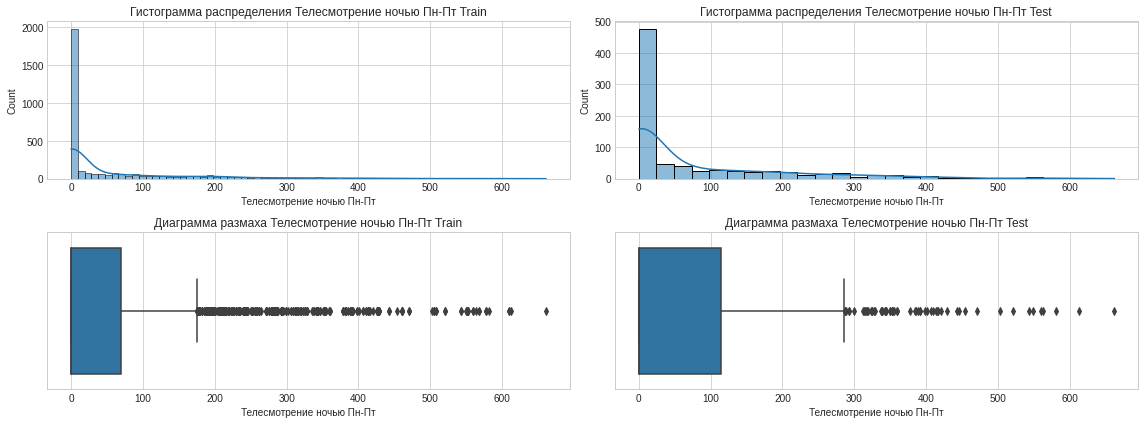

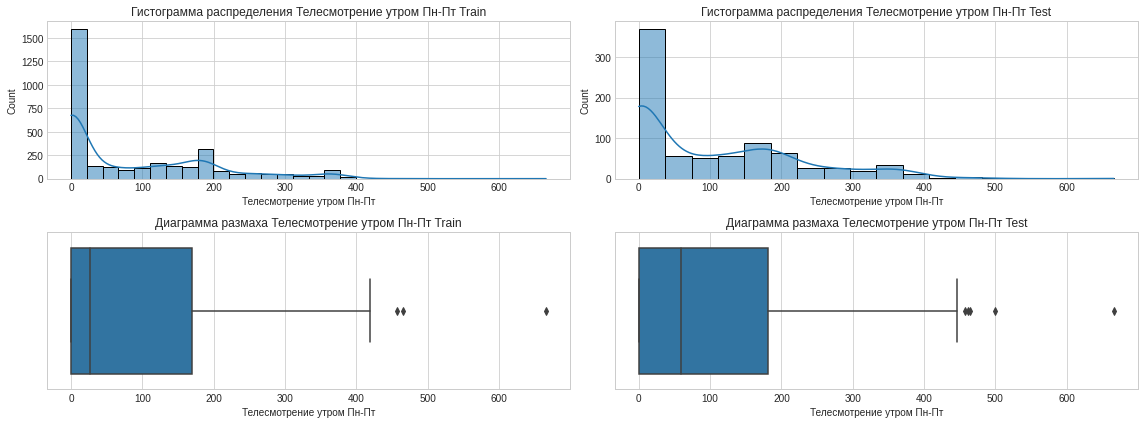

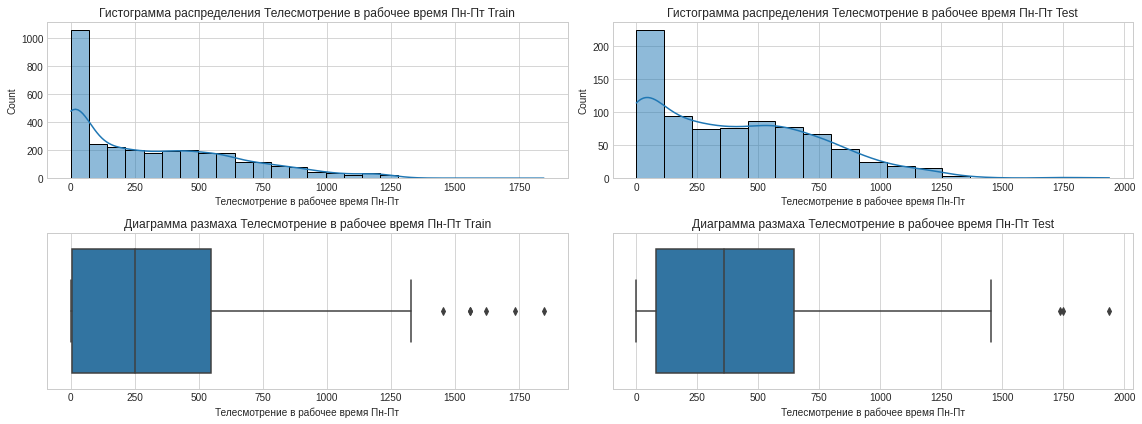

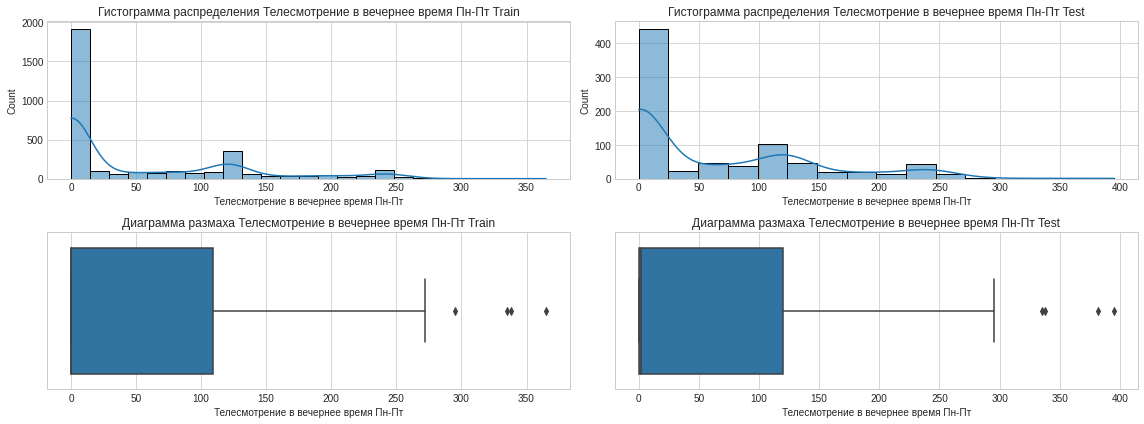

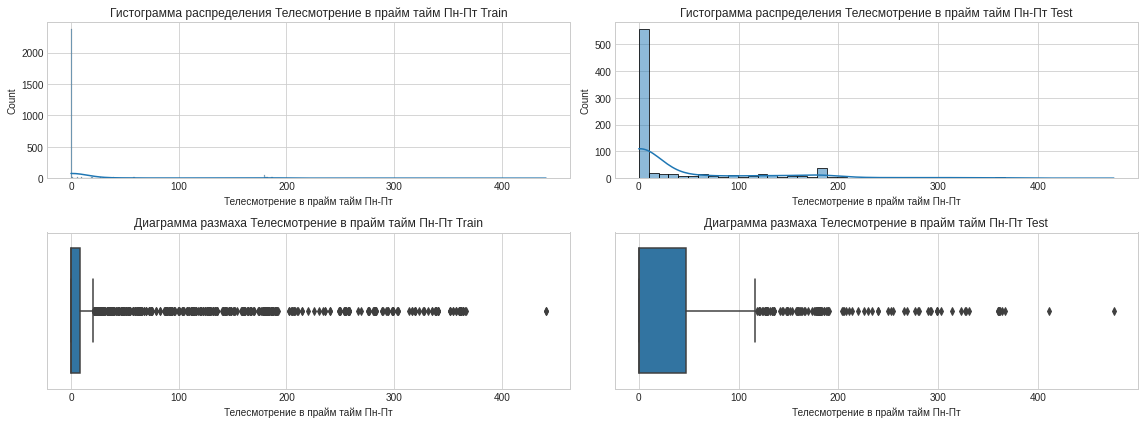

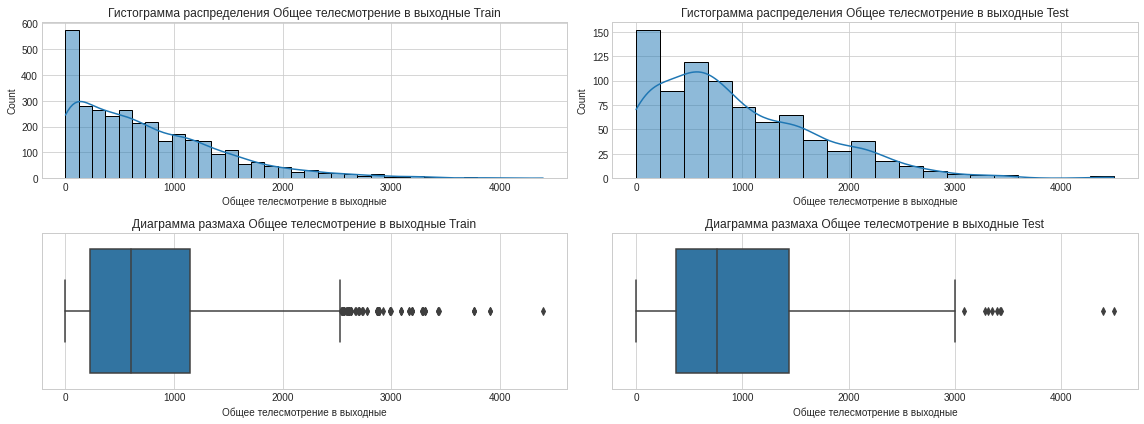

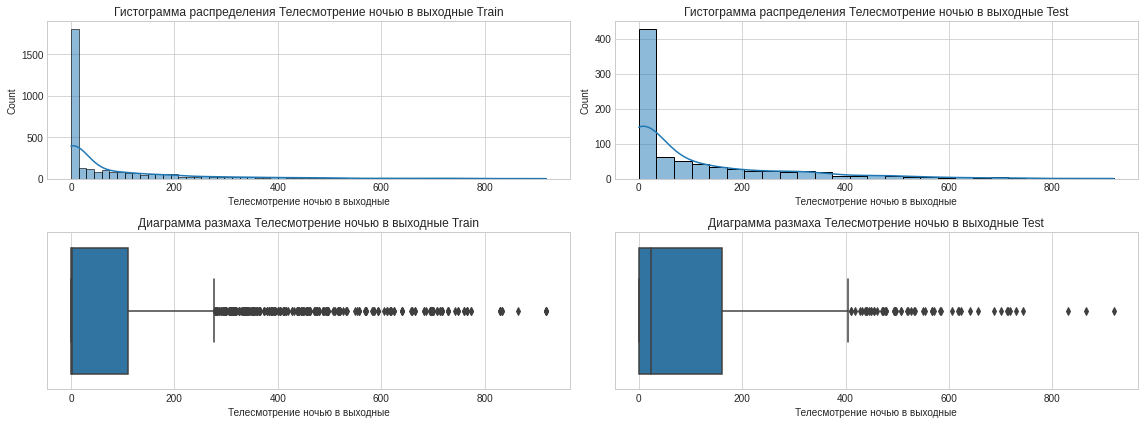

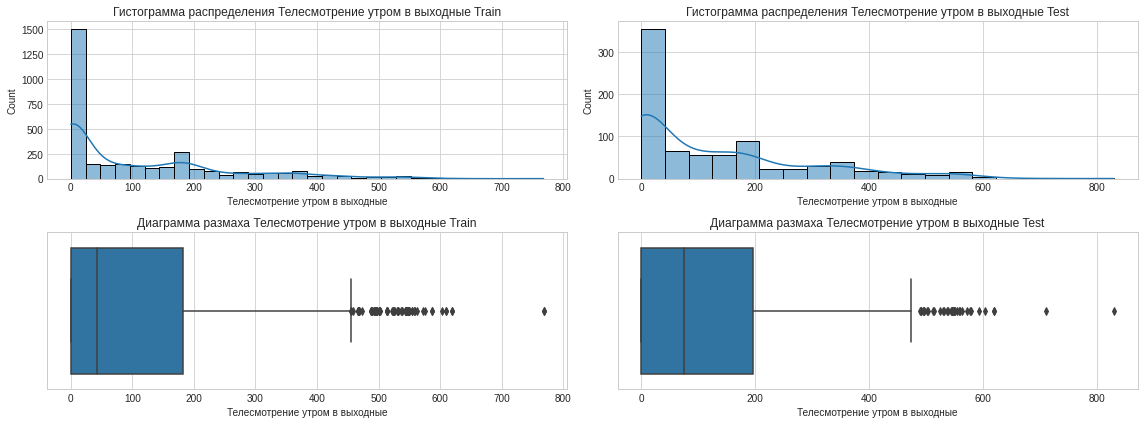

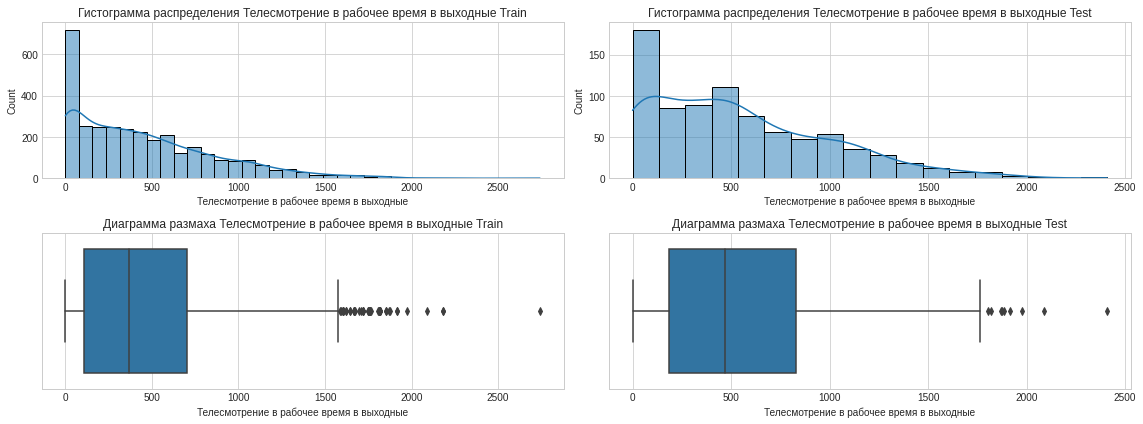

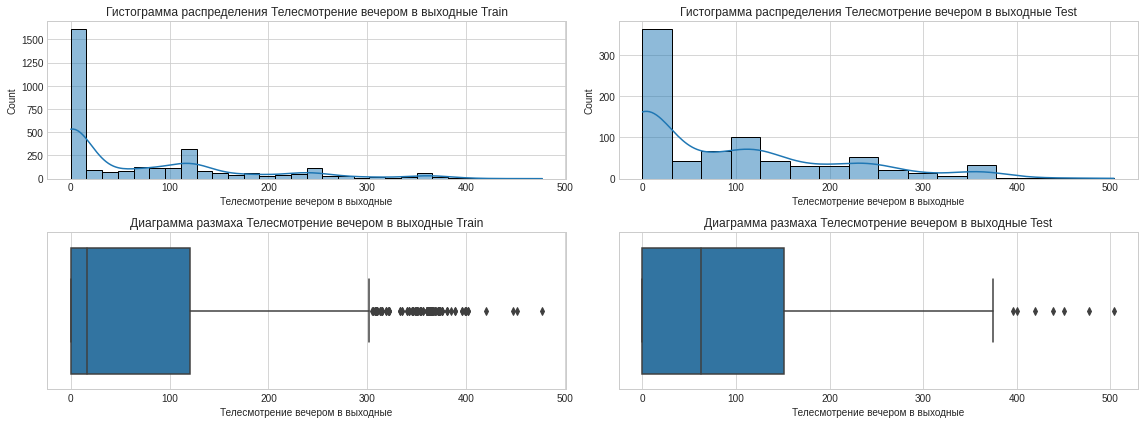

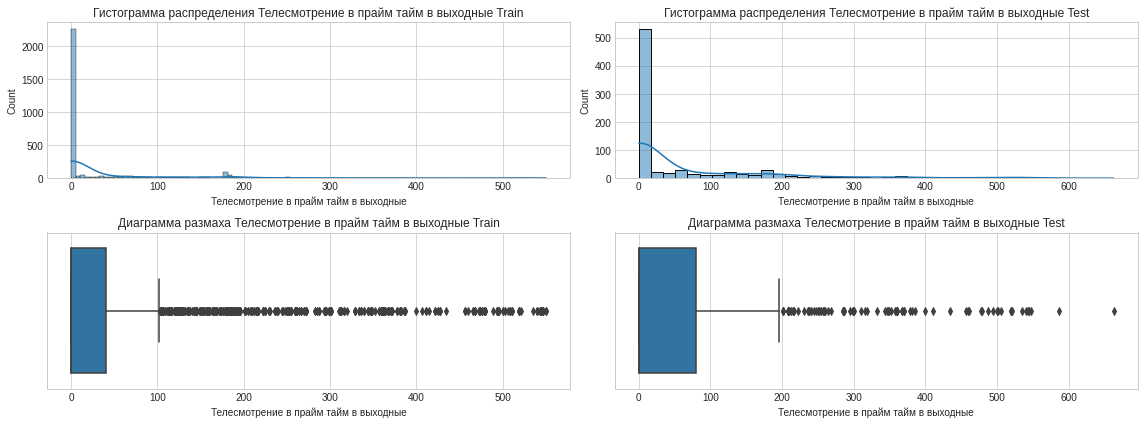

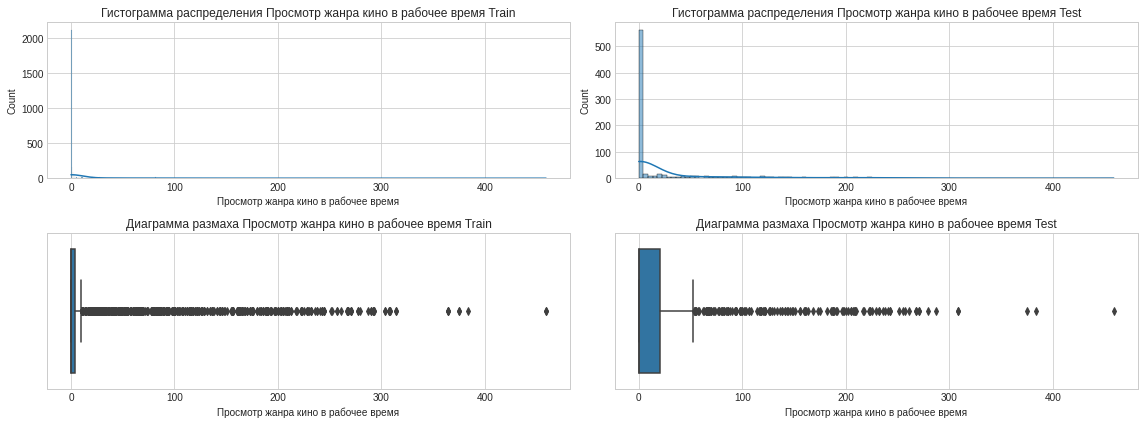

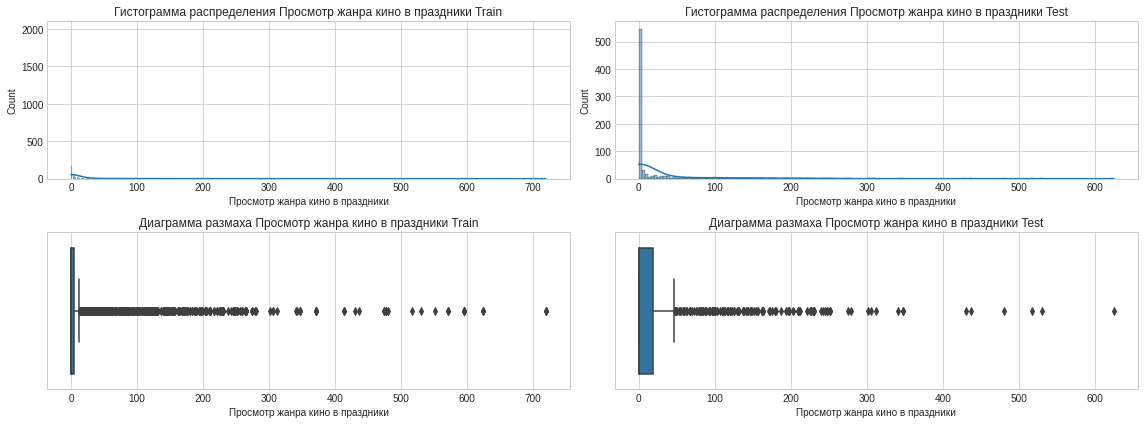

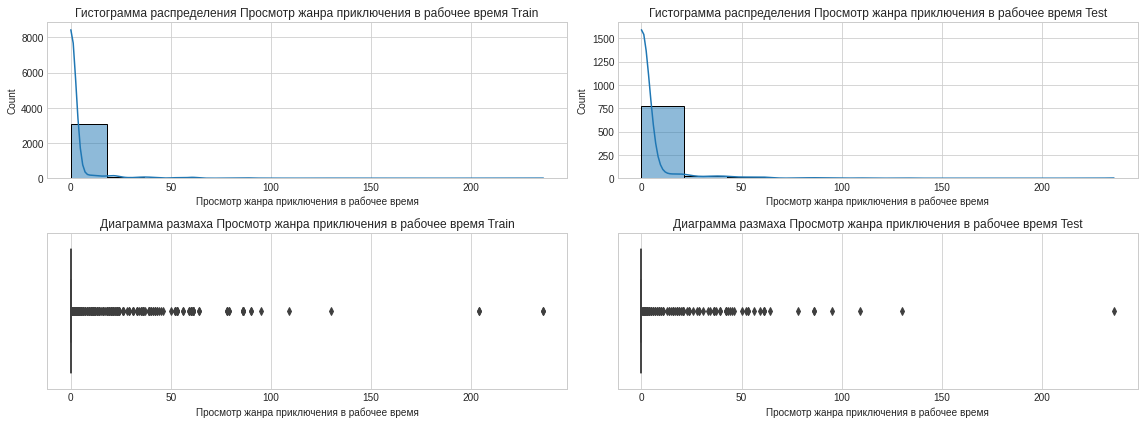

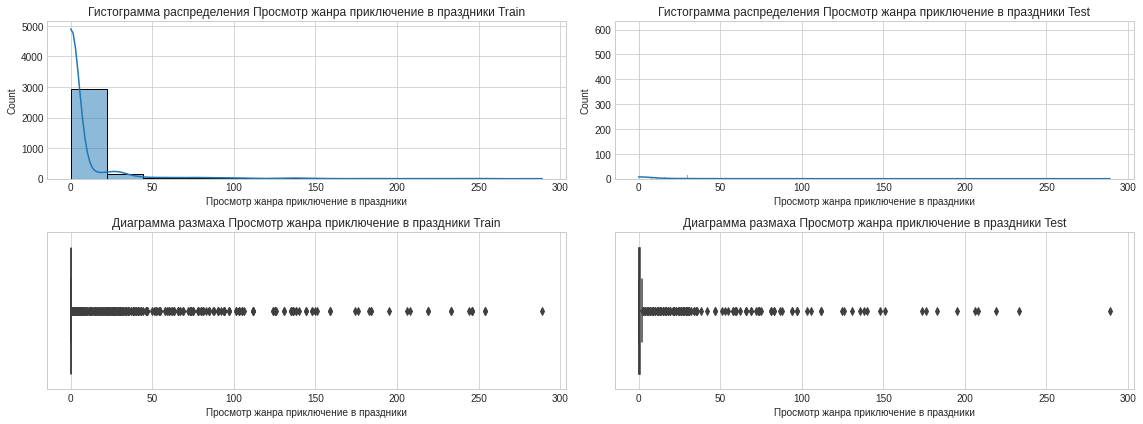

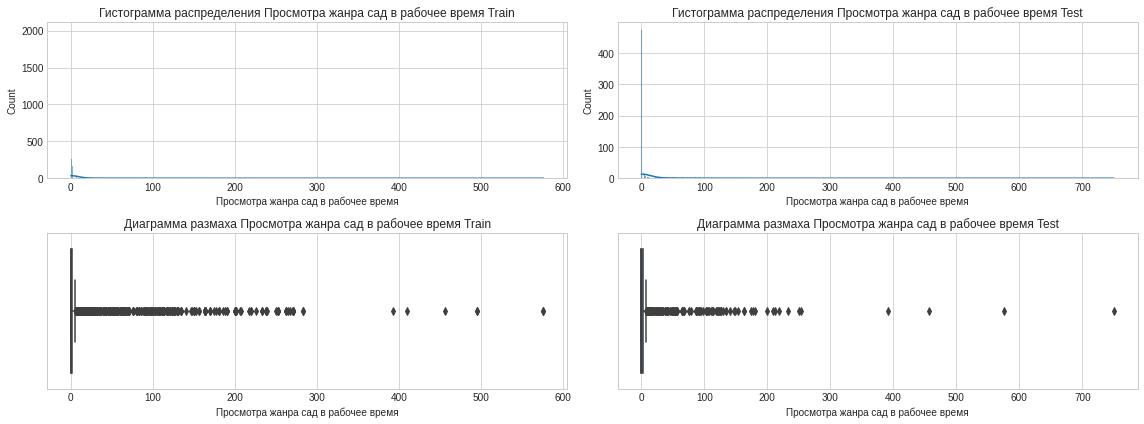

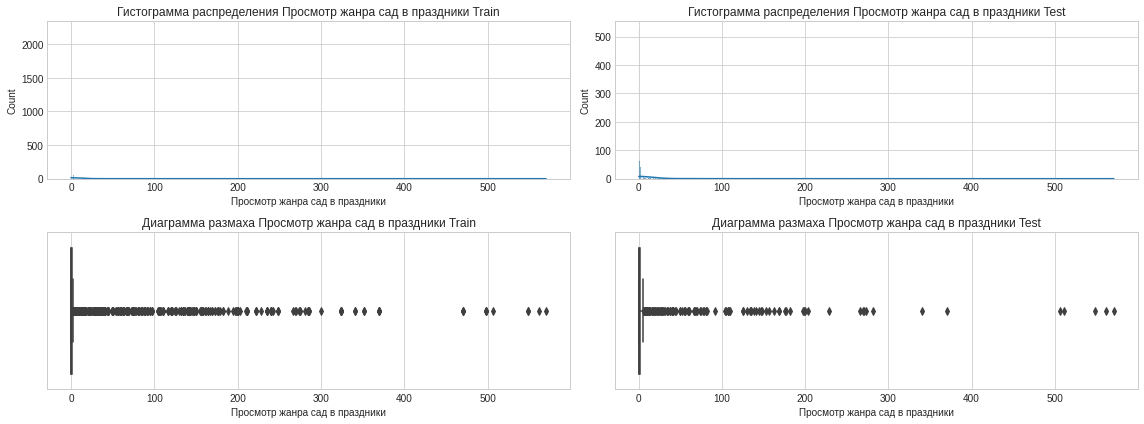

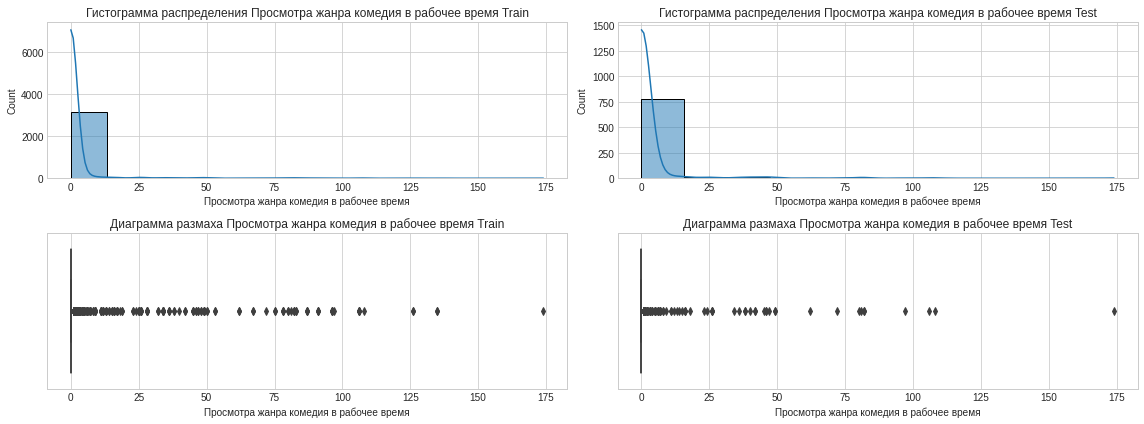

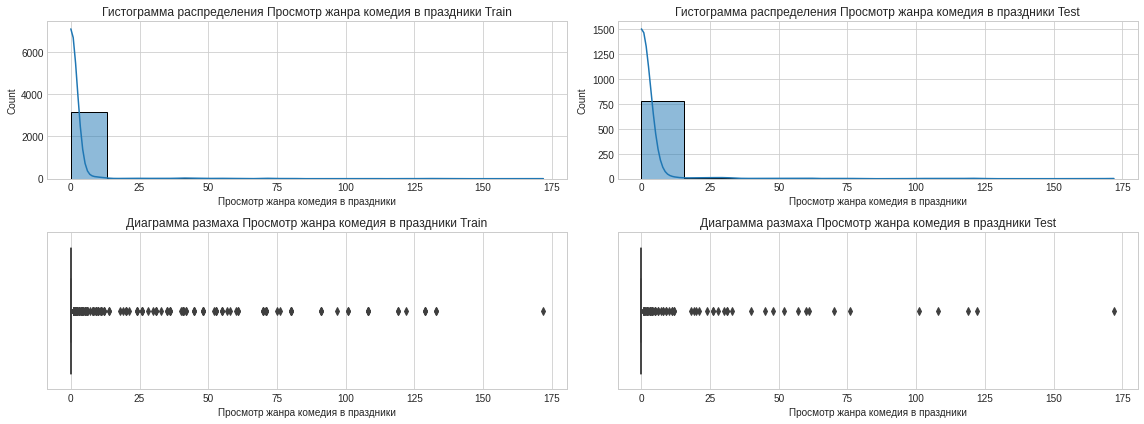

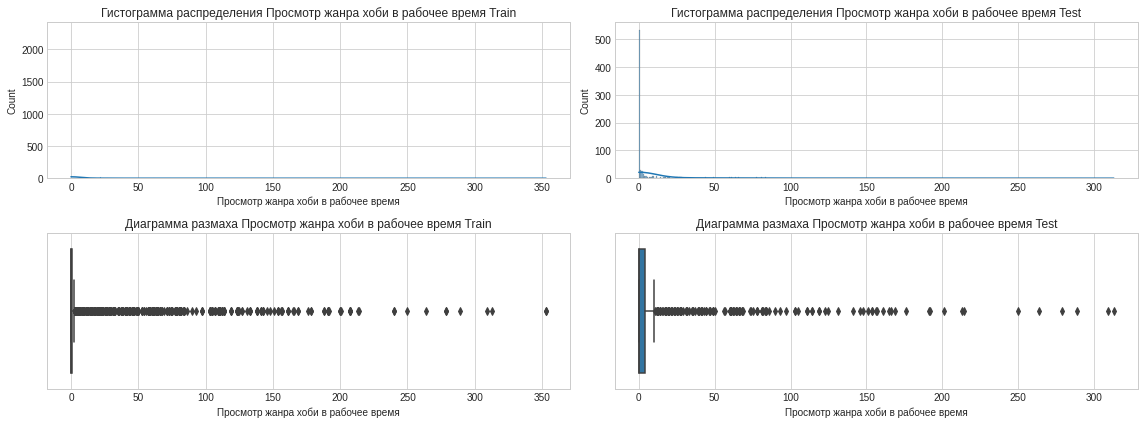

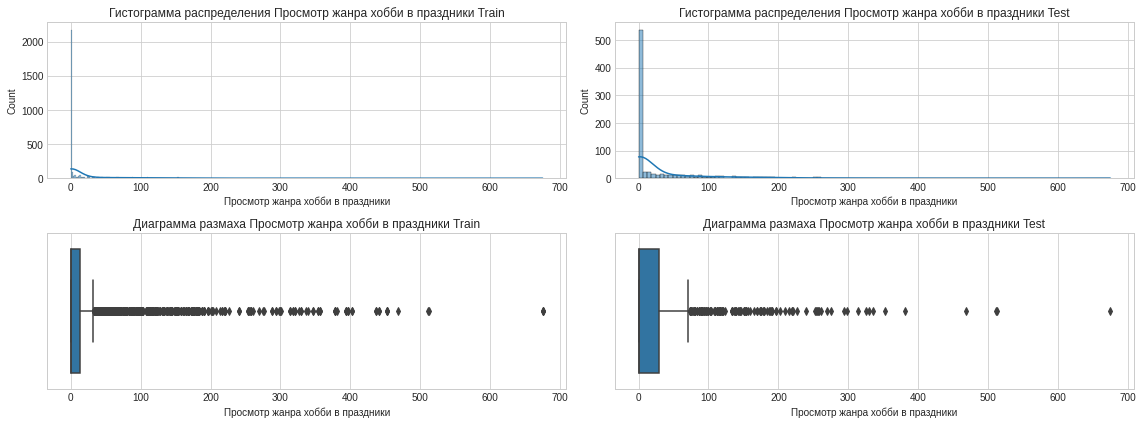

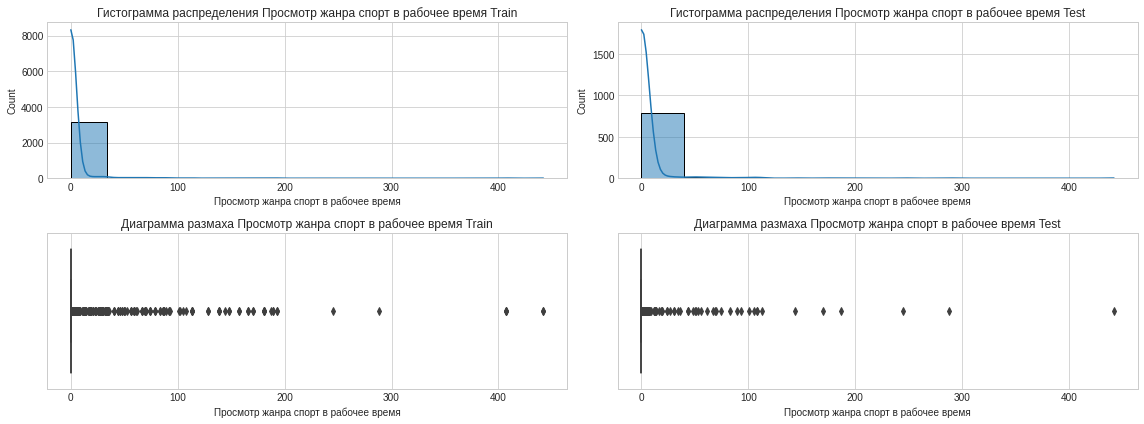

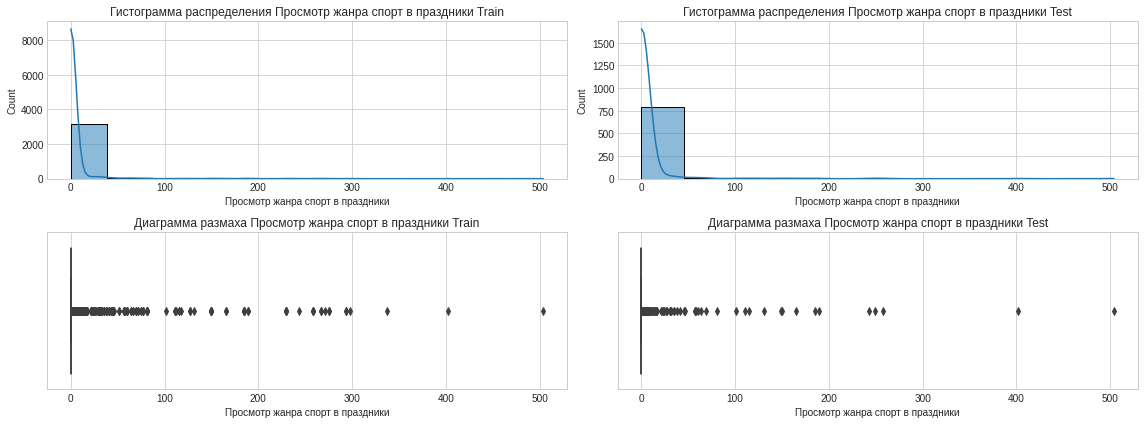

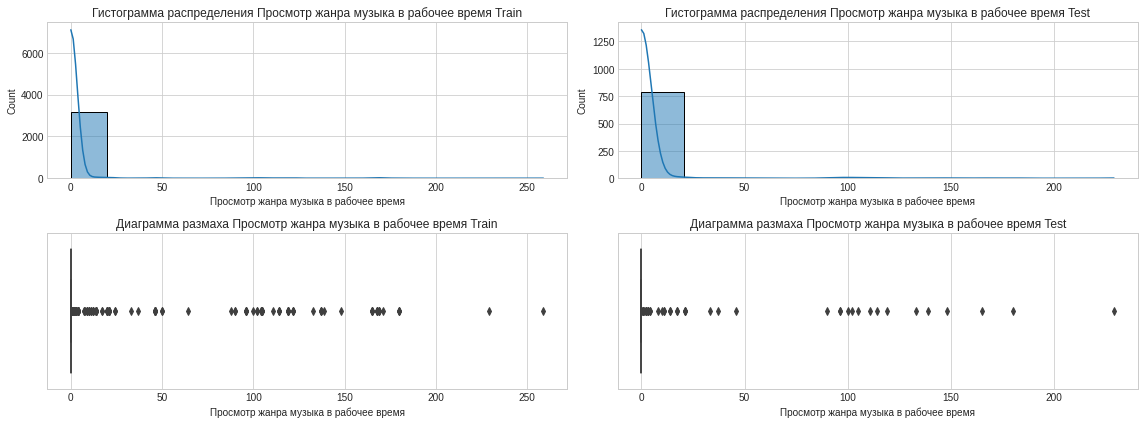

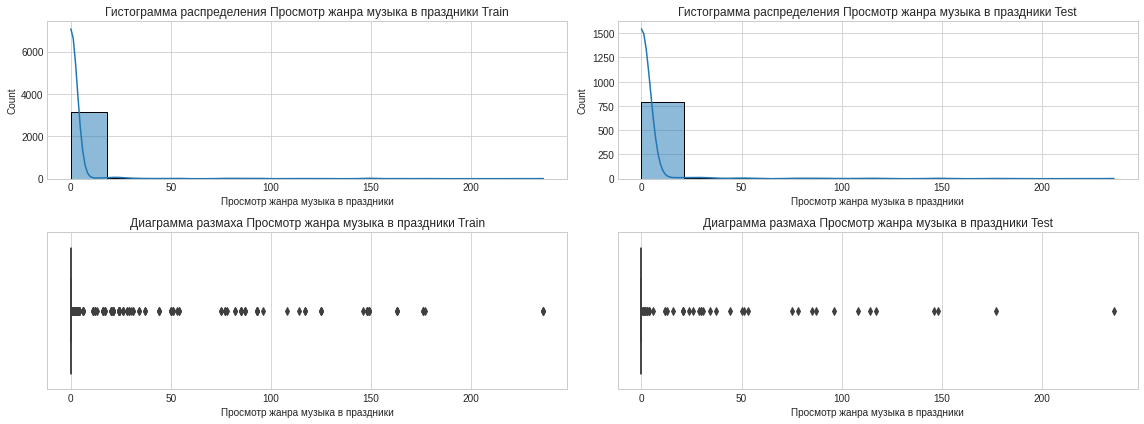

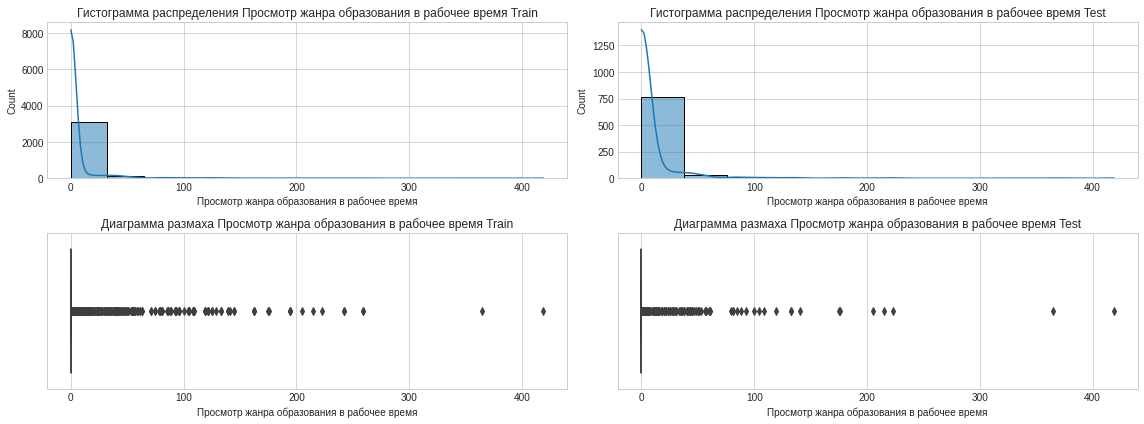

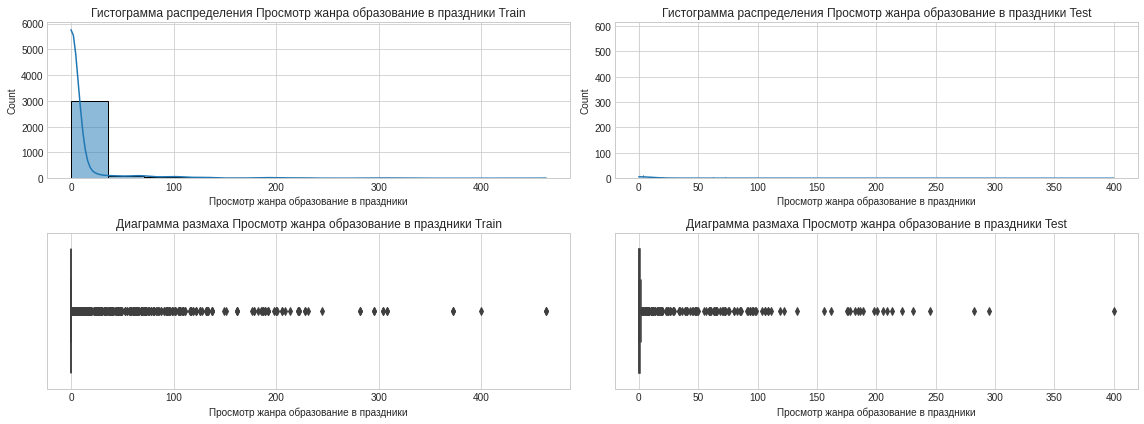

In [14]:
for col in numeric:
  get_num_plot(col)

- Ошибочных отрицательных данных по телесмотрению нет
- Все количественные признаки имеют нессиметричное распределение с большим хвостом в правую сторону - в большинстве случаев это связано с преобладанием нулевых значений, т.е. отсутствию активности пользователей
- Во многих признаках присутствует большое количество выбросов - их необходимо будет обработать перед машинным обучением, а предпочтение отдать модели, устойчивой к выбросам.
- Возможно, следует опустить те признаки, где распределения значительно различаются и\или данные в них в большинстве равны нулю 

### Баланс классов в целевых признаках

In [15]:
# Определим функцию для отображения распределения целевых признаков
def get_target_barplot(column, size=(8,4)):

  values = data_train[column].value_counts().sort_index()

  plt.figure(figsize=size)

  sns.barplot(x=values.index, y=values)
  plt.title(f'Распределение целевого признака {column}')
  plt.xlabel(f'{column}')
  plt.xticks(rotation=15)
  plt.ylabel(f'Частота')
  
  plt.tight_layout()
  plt.show()

  result = pd.concat(
      [values,
       data_train[column].value_counts(normalize=True).sort_index()
       ], axis=1)
  result.columns = ['Количество наблюдений', f'Распределение {column}']

  display(
      result.style.format(
          '{:.2%}'.format, subset=[f'Распределение {column}']
          ))

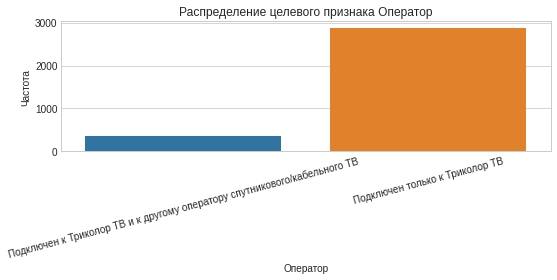

,Количество наблюдений,Распределение Оператор
Подключен к Триколор ТВ и к другому оператору спутникового/кабельного ТВ,361,11.13%
Подключен только к Триколор ТВ,2883,88.87%


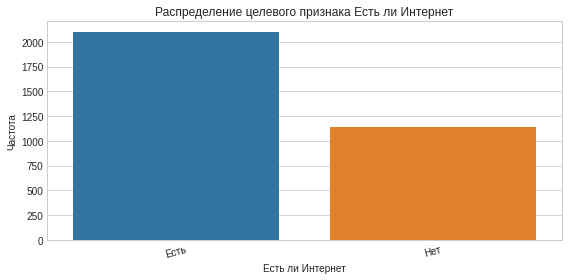

,Количество наблюдений,Распределение Есть ли Интернет
Есть,2100,64.73%
Нет,1144,35.27%


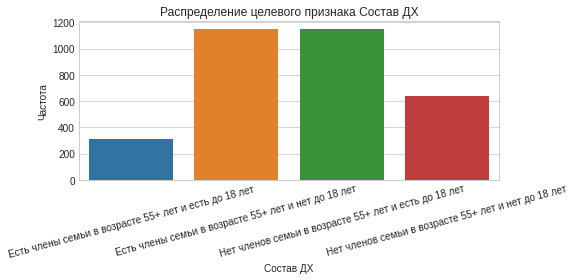

,Количество наблюдений,Распределение Состав ДХ
Есть члены семьи в возрасте 55+ лет и есть до 18 лет,313,9.65%
Есть члены семьи в возрасте 55+ лет и нет до 18 лет,1149,35.42%
Нет членов семьи в возрасте 55+ лет и есть до 18 лет,1147,35.36%
Нет членов семьи в возрасте 55+ лет и нет до 18 лет,635,19.57%


In [16]:
for col in target:
  get_target_barplot(col)

Заметен ощутимый дисбаланс во всех целевых признаках (особенно в признаке Оператор) - это необходимо учесть при обучении, при этом предпочтение стоит отдать деревянным моделям

## Подготовка данных

### Feature Engineering

Известно, что первые три цифры почтового индекса отвечают за код города, а последние три - за номер почтового отделения. Используем код города как дополнительный признак

In [17]:
# Сверим, что все почтовые индексы у нас верные
print(data_train['Почтовый индекс'].apply(lambda x: len(str(x)) != 6).sum())
print(data_test['Почтовый индекс'].apply(lambda x: len(str(x)) != 6).sum())

9
0


In [18]:
data_train[data_train['Почтовый индекс'].apply(lambda x: len(str(x)) != 6)]['Почтовый индекс']

527           0
533     6177000
849           0
1415          0
2508    6177000
2622          0
2845          0
3065          0
3176    6177000
Name: Почтовый индекс, dtype: int64

In [19]:
# Заменим строки с ошибочным почтовым индексом на медианные по ФО и насел. пункту
data_train['Почтовый индекс'].replace([0,6177000], np.nan, inplace=True)

data_train['Почтовый индекс'].fillna(
    data_train.groupby(['ФО', 'Тип нас.пункта'])['Почтовый индекс']
    .transform('median'), inplace=True
    )

In [20]:
data_train['Код города'] = data_train['Почтовый индекс'].apply(lambda x: str(x)[:3]).astype(int)
data_test['Код города'] = data_test['Почтовый индекс'].apply(lambda x: str(x)[:3]).astype(int)

In [21]:
# Запишем признаки-идентификаторы
id_train = data_train['id']
hhid_train = data_train['hhid']
id_test = data_test['id']
hhid_test = data_test['hhid']

In [22]:
# Избавимся от неинформативных колонок
data_train = data_train.drop(['id', 'hhid', 'Почтовый индекс'], axis=1)
data_test = data_test.drop(['id', 'hhid', 'Почтовый индекс'], axis=1)

### Исследование пропусков

In [23]:
data_train.isna().sum()[lambda x: x>0]

Телесмотрение утром          25
Общее телесмотрение Пн-Пт    25
Размер ДХ                    25
Тип нас.пункта               25
dtype: int64

In [24]:
data_test.isna().sum()[lambda x: x>0]

Series([], dtype: int64)

Явные пропуски наличествуют только в тренировочных данных, и их не так много. Рассмотрим поближе

<AxesSubplot:>

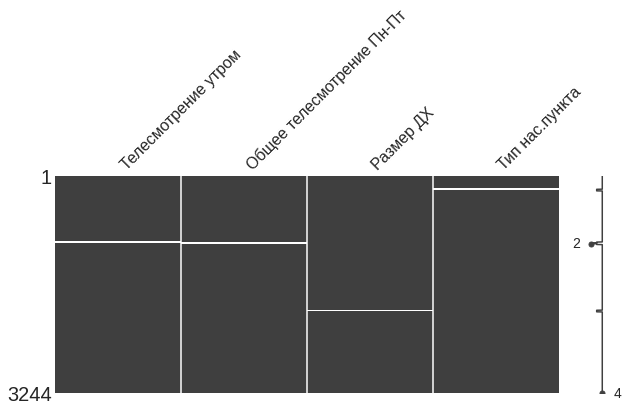

In [25]:
msno.matrix(
    data_train.loc[:,data_train.isna().any()], 
    figsize=(10,4)
    )

<AxesSubplot:>

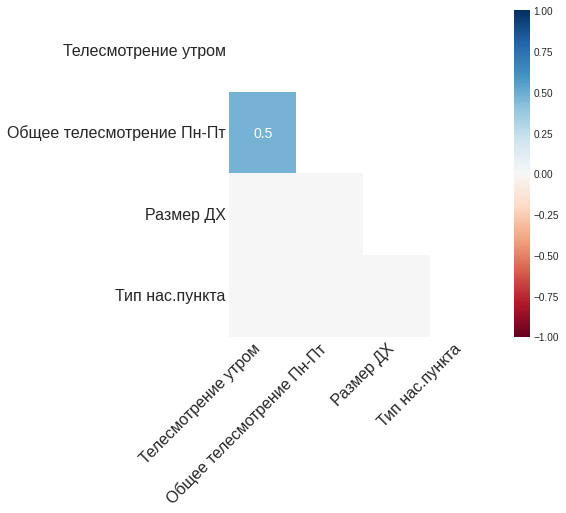

In [26]:
msno.heatmap(data_train, figsize=(6,6))

Корреляция между количественными признаками телесмотрения объяснима - эти признаки связаны друг с другом.

Мы можем восстановить эти признаки по данным других столбцов - вычесть из общего телесмотрения соответствующие признаки по другому времени.

Восстановить тип. нас. пункта можно по коду города и Федеральному округу.

Явным образом восстановить пропуски в признаке Размер ДХ не представляется возможным, лучше всего их удалить.

In [27]:
data_train['Телесмотрение утром'].fillna(
    data_train['Общее телесмотрение'] - 
    data_train['Телесмотрение ночью'] -
    data_train['Телесмотрение в рабочее время'] -
    data_train['Телесмотрение в вечернее время'] -
    data_train['Телесмотрение в прайм тайм']
, inplace=True)

In [28]:
data_train['Общее телесмотрение Пн-Пт'].fillna(
    data_train['Телесмотрение утром Пн-Пт'] + 
    data_train['Телесмотрение ночью Пн-Пт'] +
    data_train['Телесмотрение в рабочее время Пн-Пт'] +
    data_train['Телесмотрение в вечернее время Пн-Пт'] +
    data_train['Телесмотрение в прайм тайм Пн-Пт']
, inplace=True)

In [29]:
data_train['Тип нас.пункта'].fillna(
    data_train.groupby(['ФО', 'Код города'])['Тип нас.пункта']
    .transform('first'), inplace=True)

In [30]:
data_train = data_train.dropna().reset_index(drop=True)

### Кодирование данных

### Кодирование категориальных признаков

In [31]:
data_ordinal_train = encoder.fit_transform(data_train.loc[:, categorical[1:]])
data_ordinal_test = encoder.transform(data_test.loc[:, categorical[1:]])

In [32]:
data_train.loc[:, categorical[1:]] = pd.DataFrame(
    data_ordinal_train, columns=categorical[1:])

data_test.loc[:, categorical[1:]] = pd.DataFrame(
    data_ordinal_test, columns=categorical[1:])

### Кодирование целевых признаков

In [33]:
for col in target:
  print(data_train[col].unique())

['Подключен только к Триколор ТВ'
 'Подключен к Триколор ТВ и к другому оператору спутникового/кабельного ТВ']
['Нет' 'Есть']
['Нет членов семьи в возрасте 55+ лет и есть до 18 лет'
 'Есть члены семьи в возрасте 55+ лет и нет до 18 лет'
 'Нет членов семьи в возрасте 55+ лет и нет до 18 лет'
 'Есть члены семьи в возрасте 55+ лет и есть до 18 лет']


In [34]:
data_train['Оператор'] = np.where(
    data_train['Оператор'] == 'Подключен только к Триколор ТВ', 1, 0)

data_train['Есть ли Интернет'] = np.where(
    data_train['Есть ли Интернет'] == 'Есть', 1, 0)

data_train['Состав ДХ'] = label_encoder.fit_transform(data_train['Состав ДХ'])

### Исследование взаимосвязей

Мы можем оценить влияние категориальных признаков на целевые с помощью Коэффициента Крамера - мере связи двух номинальных переменных на основе критерия Хи-квадрат

In [35]:
for y in target:
  arr = []
  for col in categorical + ['Код города']:

    arr.append(nominal.cramers_v(data_train[col], data_train[y]))  

  arr = pd.Series(
      arr, index=(categorical + ['Код города']),
      name=f'Cramers V {y}'
      ).sort_values(ascending=False)
  print(arr, '\n')

Код города       0.323
Размер ДХ        0.087
ФО               0.083
Тип нас.пункта   0.034
Тип ресивера     0.000
Name: Cramers V Оператор, dtype: float64 

Код города       0.346
Размер ДХ        0.202
ФО               0.150
Тип нас.пункта   0.135
Тип ресивера     0.068
Name: Cramers V Есть ли Интернет, dtype: float64 

Размер ДХ        0.471
Код города       0.347
ФО               0.092
Тип ресивера     0.085
Тип нас.пункта   0.041
Name: Cramers V Состав ДХ, dtype: float64 



Предварительно можно сказать, что Код Города и Размер ДХ - наиболее значимые переменные для целевых признаков, в то время как Тип Ресивера - наименее значимый

Для количественных признаков мы можем оценить корреляцию между ними и бинарными целевыми признаками с помощью коэффициента точечной бисериальной корреляции

In [36]:
arr = []

for col in numeric:
  arr.append(st.pointbiserialr(data_train[col], data_train['Оператор'])[0])  

arr = pd.Series(
      arr, index=numeric,
      name=f'Корреляция с признаком Оператор'
      ).sort_values(ascending=False)
      
display(arr)

Общее телесмотрение Пн-Пт                     0.088
Телесмотрение в рабочее время Пн-Пт           0.085
Телесмотрение в рабочее время                 0.078
Общее телесмотрение                           0.075
Телесмотрение вечером в выходные              0.067
Телесмотрение утром Пн-Пт                     0.065
Телесмотрение в вечернее время                0.063
Просмотр жанра сад в праздники                0.062
Телесмотрение в прайм тайм                    0.061
Телесмотрение в рабочее время в выходные      0.056
Телесмотрение в прайм тайм в выходные         0.056
Телесмотрение в прайм тайм Пн-Пт              0.053
Общее телесмотрение в выходные                0.051
Просмотра жанра комедия в рабочее время       0.047
Телесмотрение ночью Пн-Пт                     0.045
Просмотра жанра сад в рабочее время           0.042
Телесмотрение утром                           0.041
Телесмотрение в вечернее время Пн-Пт          0.041
Просмотр жанра кино в рабочее время           0.040
Просмотр жан

In [37]:
arr = []

for col in numeric:
  arr.append(st.pointbiserialr(data_train[col], data_train['Есть ли Интернет'])[0])  

arr = pd.Series(
      arr, index=numeric,
      name=f'Корреляция с признаком Есть ли Интернет'
      ).sort_values(ascending=False)
      
display(arr)

Просмотр жанра музыка в праздники             0.011
Просмотр жанра сад в праздники               -0.007
Телесмотрение вечером в выходные             -0.011
Телесмотрение в прайм тайм в выходные        -0.014
Телесмотрение в вечернее время               -0.014
Телесмотрение в вечернее время Пн-Пт         -0.014
Просмотр жанра музыка в рабочее время        -0.015
Телесмотрение в прайм тайм Пн-Пт             -0.016
Телесмотрение в прайм тайм                   -0.017
Просмотр жанра хобби в праздники             -0.018
Просмотра жанра сад в рабочее время          -0.019
Просмотр жанра образования в рабочее время   -0.034
Просмотр жанра спорт в рабочее время         -0.042
Просмотр жанра приключения в рабочее время   -0.047
Просмотр жанра хоби в рабочее время          -0.047
Телесмотрение утром Пн-Пт                    -0.048
Просмотр жанра комедия в праздники           -0.052
Просмотр жанра приключение в праздники       -0.056
Просмотр жанра спорт в праздники             -0.066
Просмотр жан

Как можно видеть, связи достаточно слабые, но стоит отметить общую тенденцию, что повышенное телесмотрение может говорить об отсутствии Интернета

### Обработка аномалий

Из графиков было видно, что слишком большое количество данных выпадают за пределы нормальных значений. Ввиду небольшого доступного набора данных, мы не можем удалить выбросы.

Были проведены следующие тесты по обработке аномалий:

- Удаление признаков с медианой и/или квантилем 0.75, равных нулю
- Удаление выбросов от 3-5х стандартных отклонений от медианы
- Масштабирование устойчивое и стандартизированное
- Усечение по межквартильному размаху

По результатам прогонов в разных конфигурациях, которые не показали рост метрик по сравнению с необработанными аномалиями, было принято решение, что лучше всего данные оставить как есть без обработки и масштабирования.

### Исследование дубликатов

In [38]:
print('Явные дубликаты в тренировочных данных:', data_train.duplicated().sum())
print('Явные дубликаты в тестовых данных:', data_test.duplicated().sum())

Явные дубликаты в тренировочных данных: 1013
Явные дубликаты в тестовых данных: 2


Количество дубликатов слишком высокое для их удаления. Оставим их как в тренировочных, так и в тестовых данных

### Составление выборок

Сверим типы данных в столбцах

In [39]:
data_dtypes = pd.concat(
    [data_train.dtypes, data_test.dtypes], 
     axis=1)

In [40]:
data_dtypes[data_dtypes[0] != data_dtypes[1]]

,0,1
Телесмотрение утром,float64,int64
Общее телесмотрение Пн-Пт,float64,int64
Размер ДХ,float64,int64
Оператор,int64,NaN
Есть ли Интернет,int64,NaN
Состав ДХ,int64,NaN


In [41]:
data_train['Размер ДХ'] = data_train['Размер ДХ'].astype(int)
data_train['Телесмотрение утром'] = data_train['Телесмотрение утром'].astype(int)
data_train['Общее телесмотрение Пн-Пт'] = data_train['Общее телесмотрение Пн-Пт'].astype(int)

In [42]:
X = data_train.drop(target, axis=1)

y_operator = data_train['Оператор']
y_internet = data_train['Есть ли Интернет']
y_hhcomp = data_train['Состав ДХ']

In [43]:
# Оператор
X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(
    X, y_operator, test_size=0.15, random_state=777, stratify=y_operator)

In [44]:
# Наличие интернета
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(
    X, y_internet, test_size=0.15, random_state=777, stratify=y_internet)

In [45]:
# Состав ДХ
X_train_hh, X_test_hh, y_train_hh, y_test_hh = train_test_split(
    X, y_hhcomp, test_size=0.15, random_state=777, stratify=y_hhcomp)

## Обучение

Используем модели градиентного бустинга, как модели, устойчивые к выбросам и дисбалансам классов

In [46]:
# Зададим сетку параметров для LGBMClassifier
params_lgb = {
    'n_estimators':opt_distr_int(100,500),
    'learning_rate':opt_distr_float(0.01,1.0),
    'max_depth':opt_distr_int(1,16)
    }

### Оператор

#### CatBoost

In [47]:
cat_model_op = CatBoostClassifier(
    random_state=777,
    eval_metric='F1',
    auto_class_weights = 'Balanced',
    verbose=0)

In [48]:
start_time = time.time()
cat_model_op.fit(
    X_train_op, y_train_op, 
    eval_set=(X_test_op, y_test_op))
time_learn_cat_op = time.time() - start_time
print(f'Время обучения модели: {time_learn_cat_op:.4f}s')

start_time = time.time()
predictions_cat_op = cat_model_op.predict(X_test_op)
predictions_proba_cat_op = cat_model_op.predict_proba(X_test_op)[:,1]
time_predict_cat_op = time.time() - start_time
print(f'Время предсказания модели: {time_predict_cat_op:.4f}s \n')

accuracy_cat_op = accuracy_score(y_test_op, predictions_cat_op)
f1_score_cat_op = f1_score(y_test_op, predictions_cat_op)
roc_auc_cat_op = roc_auc_score(y_test_op, predictions_proba_cat_op)
print(f'Accuracy модели CatBoostClassifier: {accuracy_cat_op:.3f}')
print(f'F1 модели CatBoostClassifier: {f1_score_cat_op:.3f}')
print(f'ROC-AUC модели CatBoostClassifier: {roc_auc_cat_op:.3f}')

Время обучения модели: 8.1150s
Время предсказания модели: 0.0042s 

Accuracy модели CatBoostClassifier: 0.921
F1 модели CatBoostClassifier: 0.955
ROC-AUC модели CatBoostClassifier: 0.881


#### LightGBM

In [49]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model_op = LGBMClassifier(
    random_state=777,
    class_weight='balanced')

optuna_lgb = OptunaSearchCV(
    lgb_model_op, params_lgb, cv=4, n_trials=20,
    random_state=777, scoring='f1')

optuna_lgb.fit(X_train_op, y_train_op)

lgb_model_op = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMClassifier: {optuna_lgb.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  if __name__ == '__main__':


Лучшие параметры LGBMClassifier: {'n_estimators': 368, 'learning_rate': 0.12322342927179769, 'max_depth': 12}
CPU times: user 1min 37s, sys: 2.32 s, total: 1min 40s
Wall time: 53.3 s


In [50]:
start_time = time.time()
lgb_model_op.fit(X_train_op, y_train_op)
time_learn_lgb_op = time.time() - start_time
print(f'Время обучения модели: {time_learn_lgb_op:.4f}s')

start_time = time.time()
predictions_lgb_op = lgb_model_op.predict(X_test_op)
predictions_proba_lgb_op = lgb_model_op.predict_proba(X_test_op)[:,1]
time_predict_lgb_op = time.time() - start_time
print(f'Время предсказания модели: {time_predict_lgb_op:.4f}s \n')

accuracy_lgb_op = accuracy_score(y_test_op, predictions_lgb_op)
f1_score_lgb_op = f1_score(y_test_op, predictions_lgb_op)
roc_auc_lgb_op = roc_auc_score(y_test_op, predictions_proba_lgb_op)
print(f'Accuracy модели LGBMClassifier: {accuracy_lgb_op:.3f}')
print(f'F1 модели LGBMClassifier: {f1_score_lgb_op:.3f}')
print(f'ROC-AUC модели LGBMClassifier: {roc_auc_lgb_op:.3f}')

Время обучения модели: 1.3518s
Время предсказания модели: 0.0248s 

Accuracy модели LGBMClassifier: 0.959
F1 модели LGBMClassifier: 0.977
ROC-AUC модели LGBMClassifier: 0.917


### Интернет

#### Catboost

In [51]:
cat_model_in = CatBoostClassifier(
    random_state=777,
    eval_metric='F1',
    auto_class_weights = 'Balanced',
    verbose=0)

In [52]:
start_time = time.time()
cat_model_in.fit(
    X_train_in, y_train_in, 
    eval_set=(X_test_in, y_test_in))
time_learn_cat_in = time.time() - start_time
print(f'Время обучения модели: {time_learn_cat_in:.3f}s')

start_time = time.time()
predictions_cat_in = cat_model_in.predict(X_test_in)
predictions_proba_cat_in = cat_model_in.predict_proba(X_test_in)[:,1]
time_predict_cat_in = time.time() - start_time
print(f'Время предсказания модели: {time_predict_cat_in:.3f}s \n')

accuracy_cat_in = accuracy_score(y_test_in, predictions_cat_in)
f1_score_cat_in = f1_score(y_test_in, predictions_cat_in)
roc_auc_cat_in = roc_auc_score(y_test_in, predictions_proba_cat_in)
print(f'Accuracy модели CatBoostClassifier: {accuracy_cat_in:.3f}')
print(f'F1 модели CatBoostClassifier: {f1_score_cat_in:.3f}')
print(f'ROC-AUC модели CatBoostClassifier: {roc_auc_cat_in:.3f}')

Время обучения модели: 8.022s
Время предсказания модели: 0.005s 

Accuracy модели CatBoostClassifier: 0.853
F1 модели CatBoostClassifier: 0.885
ROC-AUC модели CatBoostClassifier: 0.926


#### LightGBM

In [53]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model_in = LGBMClassifier(
    random_state=777,
    class_weight='balanced')

optuna_lgb = OptunaSearchCV(
    lgb_model_in, params_lgb, cv=4, n_trials=20,
    random_state=777, scoring='f1')

optuna_lgb.fit(X_train_in, y_train_in)

lgb_model_in = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMClassifier: {optuna_lgb.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  if __name__ == '__main__':


Лучшие параметры LGBMClassifier: {'n_estimators': 309, 'learning_rate': 0.27935121907282673, 'max_depth': 14}
CPU times: user 1min 34s, sys: 2.2 s, total: 1min 36s
Wall time: 49.5 s


In [54]:
start_time = time.time()
lgb_model_in.fit(X_train_in, y_train_in)
time_learn_lgb_in = time.time() - start_time
print(f'Время обучения модели: {time_learn_lgb_in:.3f}s')

start_time = time.time()
predictions_lgb_in = lgb_model_in.predict(X_test_in)
predictions_proba_lgb_in = lgb_model_in.predict_proba(X_test_in)[:,1]
time_predict_lgb_in = time.time() - start_time
print(f'Время предсказания модели: {time_predict_lgb_in:.3f}s \n')

accuracy_lgb_in = accuracy_score(y_test_in, predictions_lgb_in)
f1_score_lgb_in = f1_score(y_test_in, predictions_lgb_in)
roc_auc_lgb_in = roc_auc_score(y_test_in, predictions_proba_lgb_in)
print(f'Accuracy модели LGBMClassifier: {accuracy_lgb_in:.3f}')
print(f'F1 модели LGBMClassifier: {f1_score_lgb_in:.3f}')
print(f'ROC-AUC модели LGBMClassifier: {roc_auc_lgb_in:.3f}')

Время обучения модели: 1.074s
Время предсказания модели: 0.022s 

Accuracy модели LGBMClassifier: 0.861
F1 модели LGBMClassifier: 0.894
ROC-AUC модели LGBMClassifier: 0.936


### Состав ДХ

#### CatBoost

In [55]:
cat_model_hh = CatBoostClassifier(
    random_state=777,
    loss_function='MultiClass',
    eval_metric='Kappa',
    auto_class_weights = 'Balanced',
    verbose=0)

In [56]:
start_time = time.time()
cat_model_hh.fit(
    X_train_hh, y_train_hh, 
    eval_set=(X_test_hh, y_test_hh))
time_learn_cat_hh = time.time() - start_time
print(f'Время обучения модели: {time_learn_cat_hh:.3f}s')

start_time = time.time()
predictions_cat_hh = cat_model_hh.predict(X_test_hh)
time_predict_cat_hh = time.time() - start_time
print(f'Время предсказания модели: {time_predict_cat_hh:.3f}s \n')

accuracy_cat_hh = accuracy_score(y_test_hh, predictions_cat_hh)
cohen_cat_hh = cohen_kappa_score(y_test_hh, predictions_cat_hh)
print(f'Accuracy модели CatBoostClassifier: {accuracy_cat_hh:.3f}')
print(f'Cohen Kappa score модели CatBoostClassifier: {cohen_cat_hh:.3f}')

Время обучения модели: 21.913s
Время предсказания модели: 0.005s 

Accuracy модели CatBoostClassifier: 0.851
Cohen Kappa score модели CatBoostClassifier: 0.785


#### LightGBM

In [57]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model_hh = LGBMClassifier(
    random_state=777,
    class_weight='balanced',
    objective='multiclass')

optuna_lgb = OptunaSearchCV(
    lgb_model_hh, params_lgb, cv=4, n_trials=20,
    random_state=777, scoring='f1_micro')

optuna_lgb.fit(X_train_hh, y_train_hh)

lgb_model_hh = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMClassifier: {optuna_lgb.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  # Remove the CWD from sys.path while we load stuff.


Лучшие параметры LGBMClassifier: {'n_estimators': 206, 'learning_rate': 0.46317370424748183, 'max_depth': 10}
CPU times: user 5min 17s, sys: 7.04 s, total: 5min 24s
Wall time: 2min 55s


In [58]:
start_time = time.time()
lgb_model_hh.fit(X_train_hh, y_train_hh)
time_learn_lgb_hh = time.time() - start_time
print(f'Время обучения модели: {time_learn_lgb_hh:.3f}s')

start_time = time.time()
predictions_lgb_hh = lgb_model_hh.predict(X_test_hh)
time_predict_lgb_hh = time.time() - start_time
print(f'Время предсказания модели: {time_predict_lgb_hh:.3f}s \n')

accuracy_lgb_hh = accuracy_score(y_test_hh, predictions_lgb_hh)
cohen_lgb_hh = cohen_kappa_score(y_test_hh, predictions_lgb_hh)
print(f'Accuracy модели LGBMClassifier: {accuracy_lgb_hh:.3f}')
print(f'Cohen Kappa score модели LGBMClassifier: {cohen_lgb_hh:.3f}')

Время обучения модели: 2.472s
Время предсказания модели: 0.032s 

Accuracy модели LGBMClassifier: 0.867
Cohen Kappa score модели LGBMClassifier: 0.809


## Метрики

Составим таблицу полученных показателей моделей

In [59]:
chars_cat_op = [
    time_learn_cat_op, time_predict_cat_op,
    accuracy_cat_op, f1_score_cat_op, roc_auc_cat_op]

chars_lgb_op = [
    time_learn_lgb_op, time_predict_lgb_op, 
    accuracy_lgb_op, f1_score_lgb_op, roc_auc_lgb_op]    

chars_cat_in = [
    time_learn_cat_in, time_predict_cat_in, 
    accuracy_cat_op, f1_score_cat_in, roc_auc_cat_in]

chars_lgb_in = [
    time_learn_lgb_in, time_predict_lgb_in, 
    accuracy_lgb_in, f1_score_lgb_in, roc_auc_lgb_in]

chars_cat_hh = [
    time_learn_cat_hh, time_predict_cat_hh, 
    accuracy_cat_hh, cohen_cat_hh]

chars_lgb_hh = [
    time_learn_lgb_hh, time_predict_lgb_hh, 
    accuracy_lgb_hh, cohen_lgb_hh]

In [60]:
models_table = pd.DataFrame(
    data=[chars_cat_op, chars_lgb_op, chars_cat_in, chars_lgb_in],
    columns=['Время обучения, c','Время предсказания, с', 'Accuracy', 'F1 Score', 'ROC_AUC'],
    index=['Catboost Оператор', 'LightGBM Оператор', 'Catboost Интернет', 'LightGBM Интернет'])

multi_models_table = pd.DataFrame(
    data=[chars_cat_hh, chars_lgb_hh],
    columns=['Время обучения, c','Время предсказания, с', 'Accuracy', 'Cohen Kappa Score'],
    index=['Catboost Состав ДХ', 'LightGBM Состав ДХ'])

In [61]:
pd.concat([models_table, multi_models_table])

,"Время обучения, c","Время предсказания, с",Accuracy,F1 Score,ROC_AUC,Cohen Kappa Score
Catboost Оператор,8.115,0.004,0.921,0.955,0.881,NaN
LightGBM Оператор,1.352,0.025,0.959,0.977,0.917,NaN
Catboost Интернет,8.022,0.005,0.921,0.885,0.926,NaN
LightGBM Интернет,1.074,0.022,0.861,0.894,0.936,NaN
Catboost Состав ДХ,21.913,0.005,0.851,NaN,NaN,0.785
LightGBM Состав ДХ,2.472,0.032,0.867,NaN,NaN,0.809


Получить высокие метрики Accuracy в признаках было нетрудно - слишком выраженный дисбаланс классов. Но достаточно высокий ROC_AUC говорит о сильной способности модели классификации различить/правильно ранжировать вероятности классов при поступлении данных.

В мультиклассовой задаче достаточно высокий показатель Каппа говорит о высокой степени согласия - соответствия между истинными значениями и прогнозируемыми.

## Отбор моделей

### Матрица ошибок

In [62]:
plt.style.use('default')

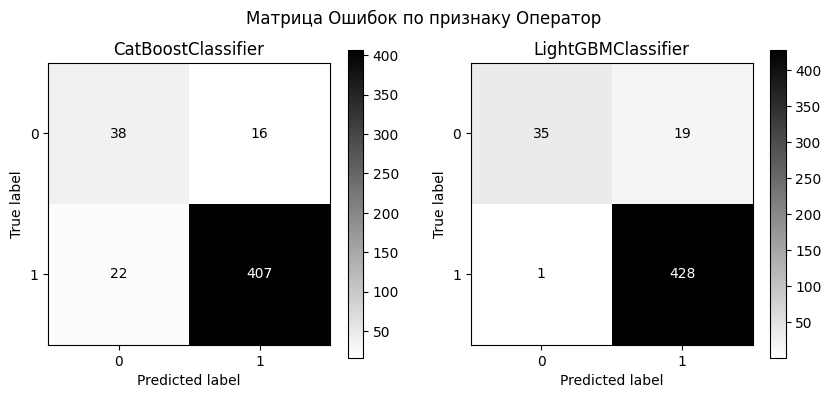

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle('Матрица Ошибок по признаку Оператор')

cat = ConfusionMatrixDisplay.from_predictions(
    y_test_op, predictions_cat_op,
    cmap='binary', ax=axes[0])
cat.ax_.set_title('CatBoostClassifier')

lgb = ConfusionMatrixDisplay.from_predictions(
    y_test_op, predictions_lgb_op,
    cmap='binary', ax=axes[1])
lgb.ax_.set_title('LightGBMClassifier')

plt.show()

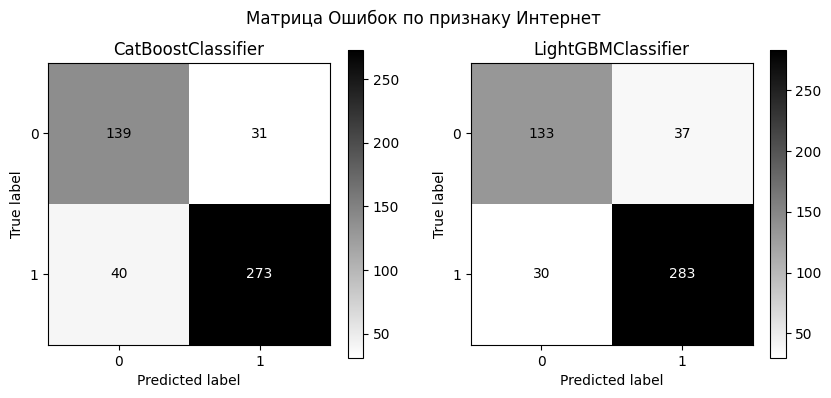

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle('Матрица Ошибок по признаку Интернет')

cat = ConfusionMatrixDisplay.from_predictions(
    y_test_in, predictions_cat_in,
    cmap='binary', ax=axes[0])
cat.ax_.set_title('CatBoostClassifier')

lgb = ConfusionMatrixDisplay.from_predictions(
    y_test_in, predictions_lgb_in,
    cmap='binary', ax=axes[1])
lgb.ax_.set_title('LightGBMClassifier')

plt.show()

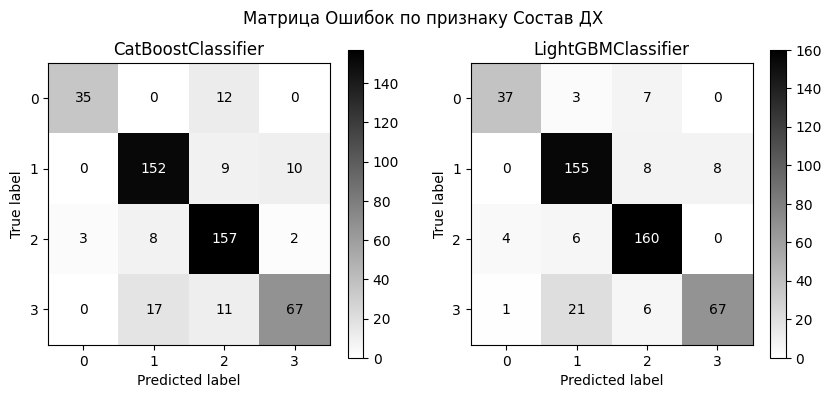

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle('Матрица Ошибок по признаку Состав ДХ')

cat = ConfusionMatrixDisplay.from_predictions(
    y_test_hh, predictions_cat_hh,
    cmap='binary', ax=axes[0])
cat.ax_.set_title('CatBoostClassifier')

lgb = ConfusionMatrixDisplay.from_predictions(
    y_test_hh, predictions_lgb_hh,
    cmap='binary', ax=axes[1])
lgb.ax_.set_title('LightGBMClassifier')

plt.show()

Несмотря на сильный дисбаланс классов, все обученные модели обладают хорошей разделяющей способностью

Отберём те модели, где количество ошибок первого и второго рода наименьшее

In [66]:
best_model_op = lgb_model_op
best_model_in = lgb_model_in
best_model_hh = lgb_model_hh

### Feature Importance

In [67]:
pd.Series(
    best_model_op.feature_importances_, 
    index=data_test.columns,
    name='Оператор'
    ).sort_values(ascending=False)

Код города                                    1055
Общее телесмотрение                            711
Телесмотрение в рабочее время                  681
Общее телесмотрение Пн-Пт                      595
Телесмотрение утром                            546
Телесмотрение в рабочее время в выходные       504
Размер ДХ                                      495
Телесмотрение в рабочее время Пн-Пт            480
Общее телесмотрение в выходные                 452
Телесмотрение вечером в выходные               370
Телесмотрение утром Пн-Пт                      358
Телесмотрение утром в выходные                 350
Тип нас.пункта                                 300
Телесмотрение в вечернее время                 275
Просмотр жанра хобби в праздники               265
Телесмотрение ночью                            264
ФО                                             263
Телесмотрение в прайм тайм                     248
Просмотра жанра сад в рабочее время            238
Телесмотрение в прайм тайм в вы

In [68]:
pd.Series(
    best_model_in .feature_importances_, 
    index=data_test.columns,
    name='Есть ли интернет'
    ).sort_values(ascending=False)

Код города                                    966
Телесмотрение в рабочее время                 574
Общее телесмотрение                           522
Телесмотрение в рабочее время в выходные      474
Общее телесмотрение в выходные                431
Телесмотрение в рабочее время Пн-Пт           392
Телесмотрение утром                           372
Размер ДХ                                     341
Телесмотрение вечером в выходные              330
Телесмотрение в вечернее время                323
Телесмотрение утром в выходные                307
Общее телесмотрение Пн-Пт                     307
Телесмотрение утром Пн-Пт                     274
ФО                                            241
Телесмотрение ночью в выходные                215
Телесмотрение ночью                           213
Тип нас.пункта                                204
Телесмотрение в прайм тайм                    202
Телесмотрение в прайм тайм в выходные         194
Просмотр жанра сад в праздники                179


In [69]:
pd.Series(
    best_model_hh.feature_importances_, 
    index=data_test.columns,
    name='Состав ДХ'
    ).sort_values(ascending=False)

Код города                                    2273
Общее телесмотрение                           1265
Телесмотрение в рабочее время в выходные      1144
Телесмотрение в рабочее время                 1089
Общее телесмотрение в выходные                1048
Размер ДХ                                      920
Общее телесмотрение Пн-Пт                      885
Телесмотрение утром                            788
Телесмотрение в рабочее время Пн-Пт            754
Телесмотрение в вечернее время                 706
Тип нас.пункта                                 652
Телесмотрение утром в выходные                 616
ФО                                             590
Телесмотрение вечером в выходные               566
Телесмотрение в вечернее время Пн-Пт           546
Телесмотрение утром Пн-Пт                      509
Телесмотрение ночью                            499
Просмотра жанра сад в рабочее время            407
Телесмотрение в прайм тайм                     397
Телесмотрение ночью в выходные 

Как можно видеть, в первую очередь модели совершают выбор, делая разделения по следующим признакам:
- Город (его код)
- Общее телесмотрение
- Телесмотрение в рабочее время
- Размер ДХ

Наименее важными признаками являются просмотры по жанрам

## Получение результатов

Рассмотрим пример полученных результатов

In [70]:
data_sample

,id,Оператор,Есть ли Интернет,Состав ДХ
0,1,Подключен только к Триколор ТВ,Нет,Нет членов семьи в возрасте 55+ лет и есть до ...
1,2,Подключен к Триколор ТВ и к другому оператору ...,Есть,Есть члены семьи в возрасте 55+ лет и нет до 1...
2,3,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и нет до 1...
3,4,Подключен к Триколор ТВ и к другому оператору ...,Нет,Есть члены семьи в возрасте 55+ лет и есть до ...


Обучим отобранные модели на всех данных

In [71]:
best_model_op.fit(X, y_operator)
best_model_op.fit(X, y_internet)
best_model_hh.fit(X, y_hhcomp)

LGBMClassifier(class_weight='balanced', learning_rate=0.46317370424748183,
               max_depth=10, n_estimators=206, objective='multiclass',
               random_state=777)

In [72]:
# Получим предсказания
pred_operator = best_model_op.predict(data_test)
pred_internet = best_model_in.predict(data_test)
pred_hhcomp = best_model_hh.predict(data_test)

In [73]:
# Раскодируем признаки
pred_operator = np.where(
    pred_operator == 1,
    'Подключен только к Триколор ТВ',
    'Подключен к Триколор ТВ и к другому оператору спутникового/кабельного ТВ')

pred_internet = np.where(
    pred_internet == 1,
    'Есть',
    'Нет')

pred_hhcomp = label_encoder.inverse_transform(pred_hhcomp)

pred_operator = pd.Series(pred_operator)
pred_internet = pd.Series(pred_internet)
pred_hhcomp = pd.Series(pred_hhcomp)

In [74]:
submission_a2 = pd.concat([id_test, pred_operator, pred_internet, pred_hhcomp], axis=1)
submission_a2.columns = data_sample.columns
submission_a2

,id,Оператор,Есть ли Интернет,Состав ДХ
0,3244,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и нет до 1...
1,3245,Подключен только к Триколор ТВ,Есть,Есть члены семьи в возрасте 55+ лет и нет до 1...
2,3246,Подключен к Триколор ТВ и к другому оператору ...,Нет,Есть члены семьи в возрасте 55+ лет и нет до 1...
3,3247,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...
4,3248,Подключен к Триколор ТВ и к другому оператору ...,Нет,Есть члены семьи в возрасте 55+ лет и нет до 1...
...,...,...,...,...
806,4050,Подключен к Триколор ТВ и к другому оператору ...,Нет,Нет членов семьи в возрасте 55+ лет и есть до ...
807,4051,Подключен только к Триколор ТВ,Есть,Есть члены семьи в возрасте 55+ лет и нет до 1...
808,4052,Подключен только к Триколор ТВ,Есть,Нет членов семьи в возрасте 55+ лет и есть до ...
809,4053,Подключен к Триколор ТВ и к другому оператору ...,Нет,Есть члены семьи в возрасте 55+ лет и нет до 1...


In [75]:
submission_a2.to_csv('/content/drive/MyDrive/kaggle_submissions/agency_a2/submission_Legoshin_Arseniy.csv', index=False)